In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = np.load(r'data/myus_binarized_processed_cropped_finalized.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'data/myus_binarized_processed_cropped_finalized.npy'

In [2]:
class DNN(nn.Module):
    """Simple MLP that maps (x,y,t)->(A_r, A_i)."""
    def __init__(self, layers):
        super().__init__()
        net = []
        for i in range(len(layers)-1):
            net.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                net.append(nn.Tanh())
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

class CGLEPINN_TimeMu(nn.Module):
    """
    PINN for Complex Ginzburg–Landau with a time-dependent, downsampled mu-field:
      mu_small shape = (Nt, Nx_down, Ny_down).
    """
    def __init__(
        self,
        layers,             # e.g. [3,64,64,2] for A(x,y,t)
        Nt, Nx_down, Ny_down,
        dt, dx, dy,
        degrade_x, degrade_y,
        delta=1.0,
        myu_init=None,      # shape (Nt, Nx_down, Ny_down)
        weight_pde=1.0,
        device='cpu'
    ):
        super().__init__()
        self.device = device
        self.delta = delta
        self.weight_pde = weight_pde

        # The net that predicts A(x,y,t)
        self.dnn = DNN(layers).to(device)

        # Store shapes, spacing
        self.Nt = Nt
        self.Nx_down = Nx_down
        self.Ny_down = Ny_down
        self.dt = dt
        self.dx = dx
        self.dy = dy
        self.degrade_x = degrade_x
        self.degrade_y = degrade_y

        # Create a trainable param for mu_small
        if myu_init is None:
            # random init
            init = torch.zeros(Nt, Nx_down, Ny_down)  # or normal, etc.
        else:
            # pass in the array you downsampled
            init = torch.tensor(myu_init, dtype=torch.float32)

        self.mu_small = nn.Parameter(init.to(device))

    def net_A(self, x, y, t):
        """Forward pass for (A_r, A_i)."""
        inp = torch.cat([x, y, t], dim=1)  # shape (batch,3)
        out = self.dnn(inp)               # shape (batch,2)
        A_r = out[:,0:1]
        A_i = out[:,1:2]
        return A_r, A_i

    def get_mu(self, x, y, t):
        """
        Convert (x,y,t) -> integer indices [i, j, k], and return mu_small[i,j,k].
        """
        # shape of x,y,t is (batch,1).
        i = (t[:,0]/self.dt).round().long().clamp(0, self.Nt-1)  # time index
        j = (x[:,0]/(self.dx*self.degrade_x)).floor().long()
        k = (y[:,0]/(self.dy*self.degrade_y)).floor().long()

        j = j.clamp(0, self.Nx_down-1)
        k = k.clamp(0, self.Ny_down-1)

        mu_vals = self.mu_small[i, j, k]  # shape (batch,)
        return mu_vals.view(-1,1)

    def pde_residual(self, x, y, t):
        """A_t = mu*A + delta Lap(A) - |A|^2 A."""
        A_r, A_i = self.net_A(x, y, t)
        mu_vals = self.get_mu(x, y, t)

        # partial derivatives wrt t:
        A_r_t = torch.autograd.grad(
            A_r, t,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_t = torch.autograd.grad(
            A_i, t,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # wrt x:
        A_r_x = torch.autograd.grad(
            A_r, x,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_x = torch.autograd.grad(
            A_i, x,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # wrt y:
        A_r_y = torch.autograd.grad(A_r, y,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True
        )[0]
        A_i_y = torch.autograd.grad(A_i, y,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True
        )[0]

        # second derivatives -> Laplacian
        A_r_xx = torch.autograd.grad(A_r_x, x,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True, retain_graph=True
        )[0]
        A_r_yy = torch.autograd.grad(A_r_y, y,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True, retain_graph=True
        )[0]

        A_i_xx = torch.autograd.grad(A_i_x, x,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True, retain_graph=True
        )[0]
        A_i_yy = torch.autograd.grad(A_i_y, y,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True, retain_graph=True
        )[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2

        f_r = A_r_t - mu_vals*A_r - self.delta*lapA_r + A_abs2*A_r
        f_i = A_i_t - mu_vals*A_i - self.delta*lapA_i + A_abs2*A_i

        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(self,
                    x_data, y_data, t_data, A_r_data, A_i_data,
                    x_eqs, y_eqs, t_eqs,
                    n_epochs=3000, lr=1e-3):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            l_pde = self.loss_pde(x_eqs, y_eqs, t_eqs)
            l_data = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss = l_data + self.weight_pde*l_pde
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch {epoch}: total={loss.item():.4e}, data={l_data.item():.4e}, pde={l_pde.item():.4e}")

            if epoch % 20000 == 0 and epoch > 0:
                checkpoint_path = f"model_real_data_checkpoint_epoch_{epoch}.pt"
                torch.save(self.state_dict(), checkpoint_path)
                print(f"Checkpoint saved at {checkpoint_path}")

    def predict(self, x_star, y_star, t_star):
        """Returns (A_r, A_i) in numpy arrays."""
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x_star, y_star, t_star)
        return A_r.cpu().numpy(), A_i.cpu().numpy()

    def predict_myu_small(self):
        """Return the current mu_small array as numpy."""
        return self.mu_small.detach().cpu().numpy()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class NOPINN(nn.Module):
    def __init__(
        self,
        layers,  # [3, 64, 64, 2]
        Nt, Nx_down, Ny_down,
        dt, dx, dy,
        degrade_x, degrade_y,
        delta=1.0,
        myu_init=None,  # shape: (Nt, Nx_down, Ny_down)
        weight_pde=1.0,
        dropout_rate=0.1,
        device='cuda:0'
    ):
        super(NOPINN, self).__init__()
        self.device = device
        self.delta = delta
        self.weight_pde = weight_pde

        self.dnn = self._build_network(layers, dropout_rate).to(device)
        self.Nt, self.Nx_down, self.Ny_down = Nt, Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy
        self.degrade_x, self.degrade_y = degrade_x, degrade_y

        if myu_init is None:
            init = torch.zeros(Nt, Nx_down, Ny_down)
        else:
            init = torch.tensor(myu_init, dtype=torch.float32)
        self.mu_small = nn.Parameter(init.to(device))

    def _build_network(self, layers, dropout_rate):
        net = []
        for i in range(len(layers) - 1):
            net.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                net.append(nn.SiLU())  # Swish activation
                net.append(nn.Dropout(dropout_rate))  # Dropout
        return nn.Sequential(*net)

    def net_A(self, x, y, t):
        inp = torch.cat([x, y, t], dim=1)
        out = self.dnn(inp)
        return out[:, 0:1], out[:, 1:2]

    def get_mu(self, x, y, t):
        i = (t[:, 0] / self.dt).round().long().clamp(0, self.Nt - 1)
        j = (x[:, 0] / (self.dx * self.degrade_x)).floor().long().clamp(0, self.Nx_down - 1)
        k = (y[:, 0] / (self.dy * self.degrade_y)).floor().long().clamp(0, self.Ny_down - 1)
        return self.mu_small[i, j, k].view(-1, 1)

    def pde_residual(self, x, y, t):
        A_r, A_i = self.net_A(x, y, t)
        mu_vals = self.get_mu(x, y, t)

        A_r_t = torch.autograd.grad(A_r, t, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_t = torch.autograd.grad(A_i, t, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_x = torch.autograd.grad(A_r, x, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_x = torch.autograd.grad(A_i, x, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_y = torch.autograd.grad(A_r, y, torch.ones_like(A_r), create_graph=True, retain_graph=True)[0]
        A_i_y = torch.autograd.grad(A_i, y, torch.ones_like(A_i), create_graph=True, retain_graph=True)[0]

        A_r_xx = torch.autograd.grad(A_r_x, x, torch.ones_like(A_r_x), create_graph=True, retain_graph=True)[0]
        A_r_yy = torch.autograd.grad(A_r_y, y, torch.ones_like(A_r_y), create_graph=True, retain_graph=True)[0]

        A_i_xx = torch.autograd.grad(A_i_x, x, torch.ones_like(A_i_x), create_graph=True, retain_graph=True)[0]
        A_i_yy = torch.autograd.grad(A_i_y, y, torch.ones_like(A_i_y), create_graph=True, retain_graph=True)[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2
        f_r = A_r_t - mu_vals * A_r - self.delta * lapA_r + A_abs2 * A_r
        f_i = A_i_t - mu_vals * A_i - self.delta * lapA_i + A_abs2 * A_i

        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(self,
                    x_data, y_data, t_data, A_r_data, A_i_data,
                    x_eqs, y_eqs, t_eqs,
                    n_epochs=3000, lr=1e-3, weight_decay=1e-4, clip_value=1.0):
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200, min_lr=1e-6)
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            l_pde = self.loss_pde(x_eqs, y_eqs, t_eqs)
            l_data = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss = l_data + self.weight_pde * l_pde
            loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), clip_value)
            optimizer.step()

            scheduler.step(loss)

            if epoch % 500 == 0:
                print(f"Epoch {epoch}: total={loss.item():.4e}, data={l_data.item():.4e}, pde={l_pde.item():.4e}")

    def predict(self, x_star, y_star, t_star):
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x_star, y_star, t_star)
        return A_r.cpu().numpy(), A_i.cpu().numpy()

    def predict_myu_small(self):
        return self.mu_small.detach().cpu().numpy()

In [4]:
from src.simulation.simulation import *

In [40]:
number_of_frames    = 250
discretization_size = 290
d                   = (0.1, 0.3, 0.3)
N                   = (number_of_frames, discretization_size, discretization_size)
myu_size            = (50, 10, 10)
myu_mstd            = (5.4, 0.6)

sim = Simulation(
    d=d,
    N=N,
    myu_size=myu_size,
    myu_mstd=myu_mstd
)

state, myu_full = sim.compute()

Computing States: 100%|██████████| 249/249 [00:03<00:00, 71.49it/s]


In [41]:
state.shape, myu_full.shape

((250, 290, 290), (250, 290, 290))

In [ ]:
# Suppose 'myu_full' has shape (Nt, Nx, Ny).
Nt, Nx, Ny = myu_full.shape

# Step A: Threshold
mean_val = np.mean(myu_full)
myu_bin = np.where(myu_full > mean_val, 255, 0).astype(np.float32)


Nx_down = 10
Ny_down = 10
# Step B: Downsample in x,y by degrade_factor_x, degrade_factor_y
degrade_x = Nx // Nx_down   # e.g. Nx=290, Nx_down=10 => degrade_x=29
degrade_y = Ny // Ny_down

myu_small_init = np.zeros((Nt, Nx_down, Ny_down), dtype=np.float32)

for i in range(Nt):
    for j in range(Nx_down):
        for k in range(Ny_down):
            block = myu_bin[
                i,                                 # time slice
                j*degrade_x:(j+1)*degrade_x,       # range in x
                k*degrade_y:(k+1)*degrade_y        # range in y
            ]
            myu_small_init[i,j,k] = block.mean()  # or block.max(), block.min(), etc.

Could not connect to 127.0.0.1: 55254
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\_pydevd_bundle\pydevd_comm.py", line 467, in start_client
    s.connect((host, port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 81, in attach_to_debugger
    debugger.connect(pydev_localhost.get_localhost(), debugger_port)
  File "C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\pydevd.py", line 704, in connect
    s = start_client(host, port)
        ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\_pydevd_bundle\pydevd_comm.py", line 467, in start_client
    s.connect((host, port))
ConnectionRefusedError: [WinError 10061] No

In [43]:
myu_small_init.shape

(250, 10, 10)

In [44]:
Nt = 250
Nx, Ny = 290, 290
dt, dx, dy = 0.1, 0.3, 0.3
Nx_down, Ny_down = 10, 10
degrade_x = Nx // Nx_down  # 290//10=29
degrade_y = Ny // Ny_down  # 29

# myu_small_init: shape (Nt, Nx_down, Ny_down)
model = CGLEPINN_TimeMu(
    layers=[3, 64, 64, 2],
    Nt=Nt, Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=1.0,
    # myu_init=myu_small_init,  # from your preprocessing
    weight_pde=0.1,
    device='cuda'
)
model.to('cuda')

CGLEPINN_TimeMu(
  (dnn): DNN(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [45]:
A_r_data = state.real  # shape (Nt, Nx, Ny)
A_i_data = state.imag  # shape (Nt, Nx, Ny)
Nt, Nx, Ny = N  # So Nt=250, Nx=290, Ny=290
t_vals = np.arange(0, Nt) * 0.1  # shape (250,)
x_vals = np.arange(0, Nx) * 0.3  # shape (290,)
y_vals = np.arange(0, Ny) * 0.3  # shape (290,)
n_data = 20000

# Randomly pick time indices
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

# Convert to physical coords
t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

# Ground-truth real, imag
Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32).view(-1, 1).to(device)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32).view(-1, 1).to(device)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32).view(-1, 1).to(device)

Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32).view(-1, 1).to(device)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32).view(-1, 1).to(device)
n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

# Convert to Tensors
x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

In [46]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t,  y_eqs_t,  t_eqs_t,
    n_epochs=200000,
    lr=1e-4
)

Epoch 0: total=4.9605e+00, data=4.9598e+00, pde=6.7178e-03
Epoch 500: total=4.1416e+00, data=4.1213e+00, pde=2.0293e-01
Epoch 1000: total=3.9223e+00, data=3.8849e+00, pde=3.7490e-01
Epoch 1500: total=3.7310e+00, data=3.6758e+00, pde=5.5110e-01
Epoch 2000: total=3.6044e+00, data=3.5403e+00, pde=6.4054e-01
Epoch 2500: total=3.5236e+00, data=3.4521e+00, pde=7.1555e-01
Epoch 3000: total=3.4565e+00, data=3.3816e+00, pde=7.4934e-01
Epoch 3500: total=3.3813e+00, data=3.3048e+00, pde=7.6454e-01
Epoch 4000: total=3.2968e+00, data=3.2180e+00, pde=7.8821e-01
Epoch 4500: total=3.2064e+00, data=3.1245e+00, pde=8.1850e-01
Epoch 5000: total=3.1154e+00, data=3.0295e+00, pde=8.5915e-01
Epoch 5500: total=3.0299e+00, data=2.9377e+00, pde=9.2130e-01
Epoch 6000: total=2.9528e+00, data=2.8567e+00, pde=9.6053e-01
Epoch 6500: total=2.8773e+00, data=2.7794e+00, pde=9.7963e-01
Epoch 7000: total=2.8015e+00, data=2.6996e+00, pde=1.0187e+00
Epoch 7500: total=2.7244e+00, data=2.6199e+00, pde=1.0449e+00
Epoch 8000: 

In [47]:
model.mu_small.shape

torch.Size([250, 10, 10])

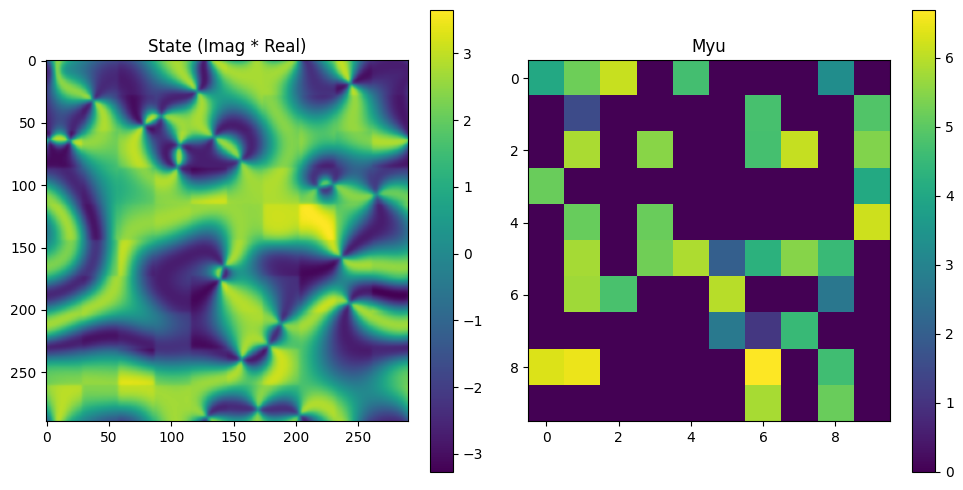

((250, 290, 290), torch.Size([250, 10, 10]))

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(state[249].imag * state[249].real)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title("State (Imag * Real)")

img2 = ax[1].imshow(model.mu_small[249].cpu().detach().numpy())
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Myu")

plt.tight_layout()
plt.show()

state.shape, model.mu_small.shape

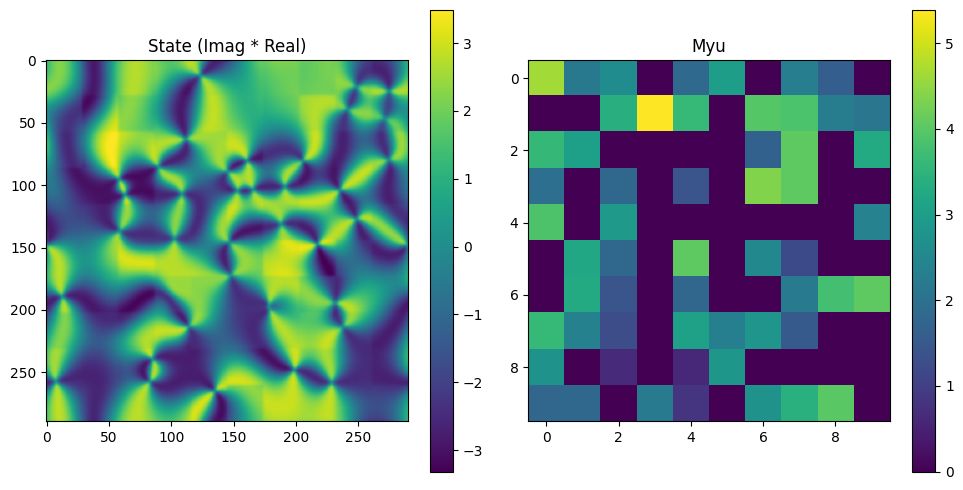

((250, 290, 290), torch.Size([250, 10, 10]))

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(state[249].imag * state[249].real)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title("State (Imag * Real)")

img2 = ax[1].imshow(model.mu_small[100].cpu().detach().numpy())
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Myu")

plt.tight_layout()
plt.show()

state.shape, model.mu_small.shape

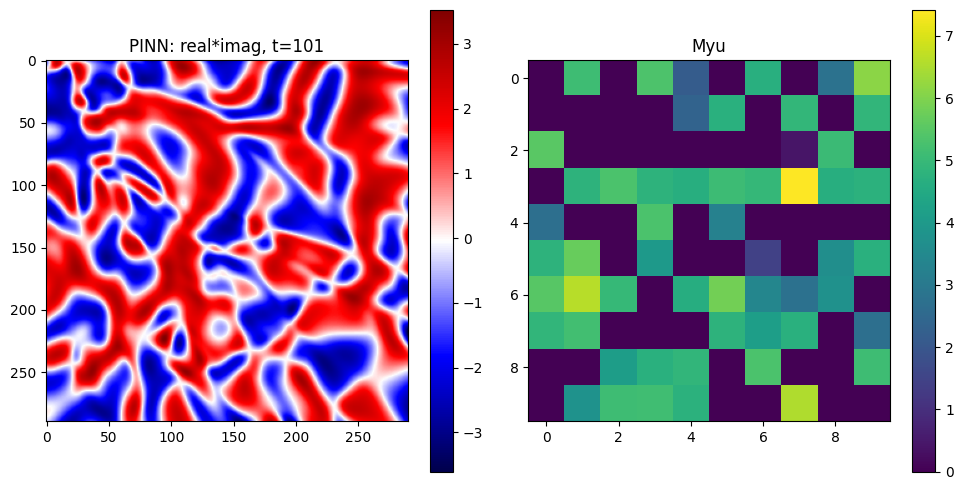

In [50]:
i = 101
# 1) PINN on a (290,290) grid, just to match the simulation's grid indices
X, Y = np.meshgrid(x_vals, y_vals)      # shape = (290,290) each
XX = X.ravel()
YY = Y.ravel()
TT = np.full_like(XX, t_vals[i])        # fill with time i => t_test_val

x_test_t = torch.tensor(XX, dtype=torch.float32).view(-1,1).to(device)
y_test_t = torch.tensor(YY, dtype=torch.float32).view(-1,1).to(device)
t_test_t = torch.tensor(TT, dtype=torch.float32).view(-1,1).to(device)

A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
A_r_pred_2d = A_r_pred.reshape(290, 290)
A_i_pred_2d = A_i_pred.reshape(290, 290)

# 2) Real×Imag for PINN
pinn_prod = A_r_pred_2d * A_i_pred_2d

# 3) Real×Imag for Simulation
sim_prod = state[ i ].real * state[ i ].imag

# 4) Plot side by side
fig, ax = plt.subplots(1,2, figsize=(10,5))
img1 = ax[0].imshow(pinn_prod, cmap='seismic')
ax[0].set_title("PINN: real*imag, t=101")
plt.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(model.mu_small[101].cpu().detach().numpy())
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Myu")
#
# img2 = ax[1].imshow(sim_prod, cmap='seismic')
# ax[1].set_title("Sim: real*imag, t=101")
# plt.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

In [32]:
model_nopinn = NOPINN(
    layers=[3, 128, 128, 2],  # Modified neural network architecture
    Nt=250, Nx_down=10, Ny_down=10,  # Same reduced spatial and temporal resolutions
    dt=0.1, dx=0.3, dy=0.3,  # Time step and spatial step sizes
    degrade_x=29, degrade_y=29,  # Downsample factors
    delta=1.0,  # Delta (PDE parameter)
    myu_init=myu_small_init,  # Preprocessed myu initialization
    weight_pde=0.1,  # Weight for PDE loss
    device='cuda'  # Use GPU if available
)
model_nopinn.to(device)  # Move model to GPU

NOPINN(
  (dnn): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [34]:
model_nopinn.train_model(
    x_data=x_data_t,
    y_data=y_data_t,
    t_data=t_data_t,
    A_r_data=Ar_data_t,
    A_i_data=Ai_data_t,
    x_eqs=x_eqs_t,
    y_eqs=y_eqs_t,
    t_eqs=t_eqs_t,
    n_epochs=10000,  # Number of training epochs
    lr=1e-3  # Learning rate
)

Epoch 0: total=7.0084e+04, data=3.6086e+01, pde=7.0047e+05
Epoch 500: total=4.8135e+00, data=4.8132e+00, pde=2.9929e-03
Epoch 1000: total=4.8133e+00, data=4.8132e+00, pde=1.1241e-03
Epoch 1500: total=4.8133e+00, data=4.8132e+00, pde=1.4643e-03
Epoch 2000: total=4.8133e+00, data=4.8132e+00, pde=1.3753e-03
Epoch 2500: total=4.8133e+00, data=4.8132e+00, pde=1.4419e-03
Epoch 3000: total=4.8133e+00, data=4.8132e+00, pde=1.1810e-03
Epoch 3500: total=4.8133e+00, data=4.8132e+00, pde=1.2323e-03
Epoch 4000: total=4.8133e+00, data=4.8132e+00, pde=1.5852e-03
Epoch 4500: total=4.8133e+00, data=4.8132e+00, pde=1.3261e-03
Epoch 5000: total=4.8133e+00, data=4.8131e+00, pde=1.4933e-03
Epoch 5500: total=4.8133e+00, data=4.8131e+00, pde=1.1991e-03
Epoch 6000: total=4.8133e+00, data=4.8132e+00, pde=1.0721e-03
Epoch 6500: total=4.8133e+00, data=4.8132e+00, pde=1.1662e-03
Epoch 7000: total=4.8133e+00, data=4.8131e+00, pde=1.6018e-03
Epoch 7500: total=4.8133e+00, data=4.8131e+00, pde=1.2442e-03
Epoch 8000: 

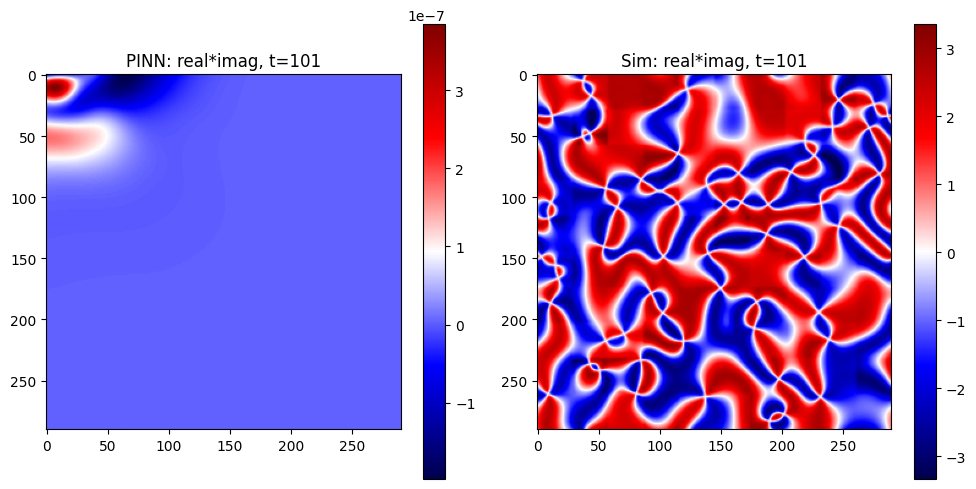

In [35]:
i = 101
# 1) PINN on a (290,290) grid, just to match the simulation's grid indices
X, Y = np.meshgrid(x_vals, y_vals)      # shape = (290,290) each
XX = X.ravel()
YY = Y.ravel()
TT = np.full_like(XX, t_vals[i])        # fill with time i => t_test_val

x_test_t = torch.tensor(XX, dtype=torch.float32).view(-1,1).to(device)
y_test_t = torch.tensor(YY, dtype=torch.float32).view(-1,1).to(device)
t_test_t = torch.tensor(TT, dtype=torch.float32).view(-1,1).to(device)

A_r_pred, A_i_pred = model_nopinn.predict(x_test_t, y_test_t, t_test_t)
A_r_pred_2d = A_r_pred.reshape(290, 290)
A_i_pred_2d = A_i_pred.reshape(290, 290)

# 2) Real×Imag for PINN
pinn_prod = A_r_pred_2d * A_i_pred_2d

# 3) Real×Imag for Simulation
sim_prod = state[ i ].real * state[ i ].imag

# 4) Plot side by side
fig, ax = plt.subplots(1,2, figsize=(10,5))
img1 = ax[0].imshow(pinn_prod, cmap='seismic')
ax[0].set_title("PINN: real*imag, t=101")
plt.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(sim_prod, cmap='seismic')
ax[1].set_title("Sim: real*imag, t=101")
plt.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

Loaded 'state' with shape: (350, 560, 966) complex128
Loaded 'myu'   with shape: (350, 560, 966) uint8


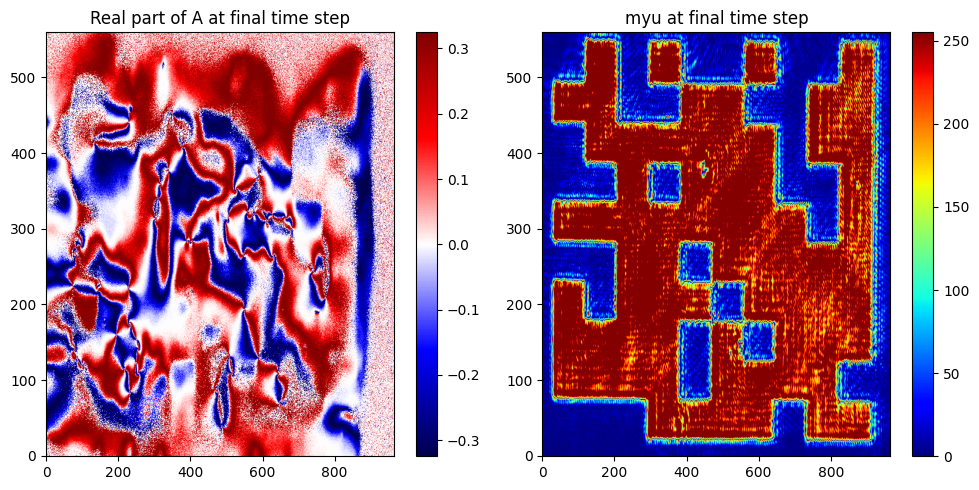

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the .npy files
#    Assuming:
#      state.npy has shape (Nt, Nx, Ny) and is complex
#      myu.npy   has shape (Nt, Nx, Ny) or (Nt, Nx, Ny) real
#    Adjust these paths/names as needed:

state = np.load("../data/states_63_2.npy")  # e.g. shape (250, 290, 290), complex
myu_full   = np.load("../data/myu_processed.npy")  # e.g. shape (250, 290, 290), real

print("Loaded 'state' with shape:", state.shape, state.dtype)
print("Loaded 'myu'   with shape:", myu_full.shape,   myu_full.dtype)

# 2) Separate real & imaginary parts of the state, if it's complex
A_r_data = state.real  # shape (Nt, Nx, Ny)
A_i_data = state.imag  # shape (Nt, Nx, Ny)

# 3) Define domain sizes & coordinate arrays
#    (If you already know dt, dx, dy from the simulation or experiment, fill them in)
Nt, Nx, Ny = state.shape
dt, dx, dy = 0.1, 0.3, 0.3   # Example values—use your actual domain steps
t_vals = np.arange(Nt) * dt  # shape (Nt,)
x_vals = np.arange(Nx) * dx  # shape (Nx,)
y_vals = np.arange(Ny) * dy  # shape (Ny,)

# 4) Quick sanity check: visualize the last time-slice for both A_r and myu
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(A_r_data[100] * A_i_data[100], cmap='seismic',
                    origin='lower', aspect='auto')
ax[0].set_title("Real part of A at final time step")
plt.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(myu_full[100], cmap='jet',
                    origin='lower', aspect='auto')
ax[1].set_title("myu at final time step")
plt.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

In [5]:
Nt, Nx, Ny = myu_full.shape

# Step A: Threshold
mean_val = np.mean(myu_full)
myu_bin = np.where(myu_full > mean_val, 255, 0).astype(np.float32)

Nx_down = 12
Ny_down = 12
# Step B: Downsample in x,y by degrade_factor_x, degrade_factor_y
degrade_x = Nx // Nx_down  # e.g. Nx=290, Nx_down=10 => degrade_x=29
degrade_y = Ny // Ny_down

myu_small_init = np.zeros((Nt, Nx_down, Ny_down), dtype=np.float32)

for i in range(Nt):
    for j in range(Nx_down):
        for k in range(Ny_down):
            block = myu_bin[
                    i,  # time slice
                    j * degrade_x:(j + 1) * degrade_x,  # range in x
                    k * degrade_y:(k + 1) * degrade_y  # range in y
                    ]
            myu_small_init[i, j, k] = block.mean()  # or block.max(), block.min(), etc.
myu_small_init.shape

(350, 12, 12)

In [8]:
Nt = 250
Nx, Ny = 560, 966
N = (250, 560, 966)
dt, dx, dy = 0.1, 0.3, 0.3
Nx_down, Ny_down = 12, 12
degrade_x = Nx // Nx_down  # 290//10=29
degrade_y = Ny // Ny_down  # 29

# myu_small_init: shape (Nt, Nx_down, Ny_down)
model = CGLEPINN_TimeMu(
    layers=[3, 64, 64, 2],
    Nt=Nt, Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=1.0,
    # myu_init=myu_small_init,  # from your preprocessing
    weight_pde=0.1,
    device='cuda'
)
model.to('cuda')
A_r_data = state.real  # shape (Nt, Nx, Ny)
A_i_data = state.imag  # shape (Nt, Nx, Ny)
Nt, Nx, Ny = N  # So Nt=250, Nx=290, Ny=290
t_vals = np.arange(0, Nt) * 0.1  # shape (250,)
x_vals = np.arange(0, Nx) * 0.3  # shape (290,)
y_vals = np.arange(0, Ny) * 0.3  # shape (290,)
n_data = 20000

# Randomly pick time indices
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

# Convert to physical coords
t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

# Ground-truth real, imag
Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32).view(-1, 1).to(device)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32).view(-1, 1).to(device)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32).view(-1, 1).to(device)

Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32).view(-1, 1).to(device)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32).view(-1, 1).to(device)
n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

# Convert to Tensors
x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

In [ ]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t, y_eqs_t, t_eqs_t,
    n_epochs=1000000,
    lr=1e-4
)

Epoch 0: total=1.9863e-01, data=1.9837e-01, pde=2.6067e-03
Epoch 500: total=1.9745e-01, data=1.9720e-01, pde=2.4220e-03
Epoch 1000: total=1.9586e-01, data=1.9562e-01, pde=2.4090e-03
Epoch 1500: total=1.9410e-01, data=1.9386e-01, pde=2.4084e-03
Epoch 2000: total=1.9244e-01, data=1.9220e-01, pde=2.4068e-03
Epoch 2500: total=1.9080e-01, data=1.9055e-01, pde=2.4439e-03
Epoch 3000: total=1.8953e-01, data=1.8928e-01, pde=2.4743e-03
Epoch 3500: total=1.8841e-01, data=1.8816e-01, pde=2.4542e-03
Epoch 4000: total=1.8740e-01, data=1.8716e-01, pde=2.4282e-03
Epoch 4500: total=1.8653e-01, data=1.8628e-01, pde=2.4438e-03
Epoch 5000: total=1.8576e-01, data=1.8551e-01, pde=2.4607e-03
Epoch 5500: total=1.8506e-01, data=1.8481e-01, pde=2.4804e-03
Epoch 6000: total=1.8442e-01, data=1.8417e-01, pde=2.5227e-03
Epoch 6500: total=1.8377e-01, data=1.8352e-01, pde=2.5195e-03
Epoch 7000: total=1.8317e-01, data=1.8291e-01, pde=2.5464e-03
Epoch 7500: total=1.8261e-01, data=1.8236e-01, pde=2.5413e-03
Epoch 8000: 

New

In [5]:
import numpy as np
import matplotlib.pyplot as plt

state = np.load("../data/test_new/states_processed_cropped.npy")
myu_full   = np.load("../data/test_new/myus_binarized_processed_cropped.npy")

print("Loaded 'state' with shape:", state.shape, state.dtype)
print("Loaded 'myu'   with shape:", myu_full.shape,   myu_full.dtype)

Loaded 'state' with shape: (350, 530, 880) complex128
Loaded 'myu'   with shape: (350, 530, 880) uint16


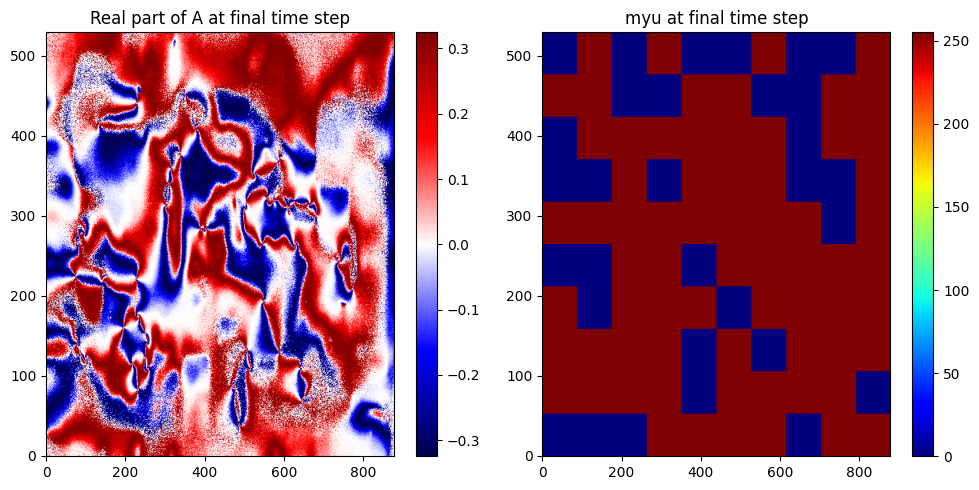

In [4]:
# 2) Separate real & imaginary parts of the state, if it's complex
A_r_data = state.real  # shape (Nt, Nx, Ny)
A_i_data = state.imag  # shape (Nt, Nx, Ny)

# 3) Define domain sizes & coordinate arrays
#    (If you already know dt, dx, dy from the simulation or experiment, fill them in)
Nt, Nx, Ny = state.shape
dt, dx, dy = 0.1, 0.3, 0.3   # Example values—use your actual domain steps
t_vals = np.arange(Nt) * dt  # shape (Nt,)
x_vals = np.arange(Nx) * dx  # shape (Nx,)
y_vals = np.arange(Ny) * dy  # shape (Ny,)

# 4) Quick sanity check: visualize the last time-slice for both A_r and myu
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

img1 = ax[0].imshow(A_r_data[100] * A_i_data[100], cmap='seismic',
                    origin='lower', aspect='auto')
ax[0].set_title("Real part of A at final time step")
plt.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(myu_full[100], cmap='jet',
                    origin='lower', aspect='auto')
ax[1].set_title("myu at final time step")
plt.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

In [6]:
import os
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def prepare_ndarray_frame(data, vmin, vmax, cmap='viridis', title=""):
    """Prepares a frame from a numpy array for video by plotting it and returning the image as an ndarray."""
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(data, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    plt.close(fig)
    return image[:, :, :3]

def create_combined_frame(pinn_prod, sim_prod, mu_pred, mu_full, vmin_pinn, vmax_pinn, vmin_mu, vmax_mu):
    """Creates a combined frame showing predicted and original states and mu-fields."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(pinn_prod, cmap="viridis", origin="lower", vmin=vmin_pinn, vmax=vmax_pinn)
    axes[0].set_title("PINN: Real × Imag")
    axes[0].axis("off")

    axes[1].imshow(sim_prod, cmap="viridis", origin="lower", vmin=vmin_pinn, vmax=vmax_pinn)
    axes[1].set_title("Sim: Real × Imag")
    axes[1].axis("off")

    axes[2].imshow(mu_pred, cmap="viridis", origin="lower", vmin=vmin_mu, vmax=vmax_mu)
    axes[2].set_title("Predicted μ")
    axes[2].axis("off")

    axes[3].imshow(mu_full, cmap="viridis", origin="lower", vmin=vmin_mu, vmax=vmax_mu)
    axes[3].set_title("Original μ")
    axes[3].axis("off")

    fig.tight_layout()
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    plt.close(fig)
    return image[:, :, :3]  # Return only RGB


def create_video(output_path, pinn_prod_frames, sim_prod_frames, mu_pred_frames, mu_full_frames, fps=30):
    """Creates a video combining frames."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    video_path = os.path.join(output_path, f"output_video_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.mp4")
    vmin_pinn, vmax_pinn = np.min(pinn_prod_frames), np.max(pinn_prod_frames)
    vmin_mu, vmax_mu = np.min(mu_pred_frames), np.max(mu_pred_frames)

    first_frame = create_combined_frame(
        pinn_prod_frames[0], sim_prod_frames[0], mu_pred_frames[0], mu_full_frames[0],
        vmin_pinn, vmax_pinn, vmin_mu, vmax_mu
    )
    height, width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    try:
        for i in tqdm(range(len(pinn_prod_frames)), desc="Creating video"):
            combined_frame = create_combined_frame(
                pinn_prod_frames[i], sim_prod_frames[i], mu_pred_frames[i], mu_full_frames[i],
                vmin_pinn, vmax_pinn, vmin_mu, vmax_mu
            )
            video_writer.write(cv2.cvtColor(combined_frame, cv2.COLOR_RGB2BGR))
        video_writer.release()
    except Exception as e:
        video_writer.release()
        raise RuntimeError(f"Failed to create video: {e}")

    print(f"Video saved at: {video_path}")


def generate_video(state, mu_full, model, x_vals, y_vals, t_vals, device, output_path):
    """
    Generates a comparison video of predicted and actual values for states and mu fields.
    """
    pinn_prod_frames, sim_prod_frames, mu_pred_frames, mu_full_frames = [], [], [], []

    # 1) Expand the predicted mu to full shape once, shape (Nt, Nx, Ny)
    mu_expanded = model.expand_myu_full(do_binarize=True, scale_255=True)

    # 2) Loop over each time index
    for i, t_val in enumerate(tqdm(t_vals, desc="Generating frames")):
        # Build a grid for the entire domain
        X, Y = np.meshgrid(x_vals, y_vals)
        XX, YY = X.ravel(), Y.ravel()
        TT = np.full_like(XX, t_val)

        x_test_t = torch.tensor(XX, dtype=torch.float32).view(-1, 1).to(device)
        y_test_t = torch.tensor(YY, dtype=torch.float32).view(-1, 1).to(device)
        t_test_t = torch.tensor(TT, dtype=torch.float32).view(-1, 1).to(device)

        # Predict A_r and A_i
        A_r_pred, A_i_pred = model.predict(x_test_t, y_test_t, t_test_t)
        A_r_pred_2d = A_r_pred.reshape(X.shape)
        A_i_pred_2d = A_i_pred.reshape(X.shape)

        # Calculate predicted product and true product
        pinn_prod = A_r_pred_2d * A_i_pred_2d
        sim_prod = state[i].real * state[i].imag

        # Get the predicted and true mu values for this time slice
        mu_pred_t = mu_expanded[i]  # Expanded predicted mu
        mu_full_t = mu_full[i]  # Ground-truth mu

        # Append frames
        pinn_prod_frames.append(pinn_prod)
        sim_prod_frames.append(sim_prod)
        mu_pred_frames.append(mu_pred_t)
        mu_full_frames.append(mu_full_t)

    # Convert to NumPy arrays
    pinn_prod_frames = np.array(pinn_prod_frames)
    sim_prod_frames = np.array(sim_prod_frames)
    mu_pred_frames = np.array(mu_pred_frames)
    mu_full_frames = np.array(mu_full_frames)

    # Create the video
    create_video(output_path, pinn_prod_frames, sim_prod_frames, mu_pred_frames, mu_full_frames)

In [7]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(nn.Tanh())
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class NPINN_PRO_MAX(nn.Module):
    """
    A 'PINN' for the Complex Ginzburg–Landau equation, where:
      - A(x,y,t) is predicted by a small neural net.
      - mu_small is a time-dependent 2D field in shape (Nt, Nx_down, Ny_down).
      - We interpret each mu_small[i,j,k] as {0 or 1}, i.e. a binary value.
      - We do 'collocation' lookups: (x,y,t) -> (i_down,j_down) -> mu_small[i, j_down, k_down].
    """

    def __init__(
        self,
        layers,               # e.g. [3,64,64,2] for A_r, A_i
        Nt, Nx, Ny,           # full domain sizes
        Nx_down, Ny_down,     # smaller, downsampled domain for mu
        dt, dx, dy,
        degrade_x, degrade_y,
        delta=0.01,
        weight_pde=1.0,
        device='cpu'
    ):
        super().__init__()
        self.device = device
        self.delta = delta
        self.weight_pde = weight_pde

        # Basic domain sizes
        self.Nt, self.Nx, self.Ny = Nt, Nx, Ny
        self.Nx_down, self.Ny_down = Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy
        self.degrade_x, self.degrade_y = degrade_x, degrade_y

        # 1) The neural net for A(x,y,t)
        self.dnn = DNN(layers).to(device)

        # 2) The trainable mu_small: shape (Nt, Nx_down, Ny_down)
        #    We'll init randomly near 0..1, or zeros, etc.
        init = 0.3*torch.randn(Nt, Nx_down, Ny_down)  # Some small random
        self.mu_small_raw = nn.Parameter(init.to(device))
        # We'll interpret this as a "logit," or just clamp each iteration, or do a step function in get_myu.

    def forward(self, x, y, t):
        """Alias so we can do model(x,y,t) -> (A_r, A_i)."""
        return self.net_A(x, y, t)

    def net_A(self, x, y, t):
        """Forward pass for A_r, A_i."""
        inp = torch.cat([x,y,t], dim=1)   # shape (batch,3)
        out = self.dnn(inp)              # shape (batch,2)
        A_r = out[:, 0:1]
        A_i = out[:, 1:2]
        return A_r, A_i

    def binarize_mu_small(self):
        """
        In practice, you might do this once per epoch, or only after training,
        because a hard step breaks gradient flow.
        This forcibly thresholds mu_small_raw -> 0 or 1 in place.
        """
        with torch.no_grad():
            self.mu_small_raw.data = (self.mu_small_raw.data > 0.0).float()

    def get_myu_collocation(self, x, y, t):
        """
        For PDE collocation: (x, y, t) -> integer indices (i, j, k).
        Then interpret mu_small_raw[i,j,k] as binary => 0 or 1,
        and if 1 => 255 if you want. Let's do 1 => 1 for PDE,
        you can scale if needed.
        """
        # 1) Convert time to index i
        i = (t[:,0] / self.dt).round().long().clamp(0, self.Nt-1)

        # 2) Convert (x,y) to (j_down, k_down)
        j_down = (x[:,0] / (self.dx*self.degrade_x)).floor().long()
        k_down = (y[:,0] / (self.dy*self.degrade_y)).floor().long()

        j_down = j_down.clamp(0, self.Nx_down-1)
        k_down = k_down.clamp(0, self.Ny_down-1)

        # 3) Access raw param -> threshold to 0/1
        #    We'll do a step function in the forward pass:
        mu_vals_raw = self.mu_small_raw[i, j_down, k_down]  # shape (batch,)

        # step function => 0 or 1
        mu_bin = (mu_vals_raw > 0.0).float()

        return mu_bin.view(-1,1)

    def pde_residual(self, x, y, t):
        """
        PDE: A_t = mu*A + delta Lap(A) - |A|^2 A
        where mu = get_myu_collocation(x,y,t).
        """
        A_r, A_i = self.net_A(x,y,t)
        mu_vals = self.get_myu_collocation(x,y,t)  # shape (batch,1)

        # partial derivatives wrt t
        A_r_t = torch.autograd.grad(A_r, t,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_t = torch.autograd.grad(A_i, t,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt x
        A_r_x = torch.autograd.grad(A_r, x,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_x = torch.autograd.grad(A_i, x,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt y
        A_r_y = torch.autograd.grad(A_r, y,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_y = torch.autograd.grad(A_i, y,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # second derivatives -> laplacian
        A_r_xx = torch.autograd.grad(A_r_x, x,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True, retain_graph=True)[0]
        A_r_yy = torch.autograd.grad(A_r_y, y,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True, retain_graph=True)[0]

        A_i_xx = torch.autograd.grad(A_i_x, x,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True, retain_graph=True)[0]
        A_i_yy = torch.autograd.grad(A_i_y, y,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True, retain_graph=True)[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2

        # Residual
        f_r = A_r_t - mu_vals*A_r - self.delta*lapA_r + A_abs2*A_r
        f_i = A_i_t - mu_vals*A_i - self.delta*lapA_i + A_abs2*A_i
        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(
        self,
    x_data, y_data, t_data, A_r_data, A_i_data,
    x_eqs, y_eqs, t_eqs,
    n_epochs=200000,
    lr=1e-3,
    model_name="MyModel",
    output_dir="./results",
    video_freq=10000,
    state_exp=None,          # shape (Nt, Nx, Ny) complex
    myu_full_exp=None,       # shape (Nt, Nx, Ny) real or binary
    x_vals=None,
    y_vals=None,
    t_vals=None,
    device="cpu"):
        """
        Train the PINN with Adam on:
          total_loss = data_loss + weight_pde * PDE_loss.

        Additionally:
          - checkpoint the model every 'video_freq' epochs
          - generate a comparison video at that time, storing it under output_dir/model_name
        """
        import os
        from datetime import datetime
        optimizer = optim.Adam(self.parameters(), lr=lr)

        # Create a subfolder for this model
        model_folder = os.path.join(output_dir, model_name)
        os.makedirs(model_folder, exist_ok=True)

        for epoch in range(n_epochs):
            optimizer.zero_grad()

            pde_l = self.loss_pde(x_eqs, y_eqs, t_eqs)
            data_l = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss = data_l + self.weight_pde * pde_l
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch={epoch}, total={loss.item():.4e}, data={data_l.item():.4e}, PDE={pde_l.item():.4e}")

            # Every 'video_freq' epochs, checkpoint + create video
            if (epoch % video_freq == 0 and epoch > 0):
                # 1) Checkpoint
                ckpt_path = os.path.join(model_folder, f"{model_name}_epoch_{epoch}.pt")
                torch.save(self.state_dict(), ckpt_path)
                print(f"Checkpoint saved at {ckpt_path}")

                # 2) Optionally generate a video comparing the model output to the real data
                #    Make sure we have the necessary arguments (state_exp, myu_full_exp, etc.)
                if (state_exp is not None) and (myu_full_exp is not None) and \
                   (x_vals is not None) and (y_vals is not None) and (t_vals is not None):
                    from datetime import datetime

                    # Name of the video
                    vid_name = f"{model_name}_epoch_{epoch}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
                    video_folder = os.path.join(model_folder, "videos")
                    os.makedirs(video_folder, exist_ok=True)

                    video_path = os.path.join(video_folder, vid_name)

                    # Call your generate_video function
                    generate_video(
                        state_exp,     # The original complex state
                        myu_full_exp,  # The original myu
                        self,          # The current model
                        x_vals, y_vals, t_vals,
                        device=device,
                        output_path=video_path  # We'll pass the prefix; the function can append .mp4, etc.
                    )

        # Final checkpoint after all epochs
        final_ckpt = os.path.join(model_folder, f"{model_name}_final_{n_epochs}.pt")
        torch.save(self.state_dict(), final_ckpt)
        print(f"Final checkpoint saved at {final_ckpt}")
        print("Training done.")

    def expand_myu_full(self, do_binarize=True, scale_255=False):
        """
        Expand mu_small to full shape (Nt, Nx, Ny) by repeating each cell degrade_x, degrade_y times.
        This can help with final visualization or 'export'.

        do_binarize: whether to threshold to 0/1
        scale_255:  whether to multiply 1->255.
        """
        with torch.no_grad():
            mu_raw = self.mu_small_raw.detach()  # shape (Nt, Nx_down, Ny_down)
            if do_binarize:
                mu_bin = (mu_raw > 0.0).float()  # (Nt, Nx_down, Ny_down)
            else:
                mu_bin = mu_raw

            if scale_255:
                mu_bin = mu_bin*255.0

            # Now expand in x,y by degrade_x, degrade_y
            # shape after repeat_interleave => (Nt, Nx_down*degrade_x, Ny_down*degrade_y) = (Nt, Nx, Ny)
            mu_full_x = mu_bin.repeat_interleave(self.degrade_x, dim=1)
            mu_full_xy = mu_full_x.repeat_interleave(self.degrade_y, dim=2)

            return mu_full_xy.cpu().numpy()  # shape (Nt, Nx, Ny)

    def predict(self, x, y, t):
        """
        Evaluate the neural net for A(x,y,t) -> (A_r, A_i) in NumPy form.
        """
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x, y, t)  # Tensors
        return A_r.cpu().numpy(), A_i.cpu().numpy()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

state = np.load("../data/test_new/states_processed_cropped.npy")
myu_full   = np.load("../data/test_new/myus_binarized_processed_cropped.npy")

print("State shape:", state.shape, state.dtype)  # (350,530,880), complex128
print("Myu shape:  ", myu_full.shape, myu_full.dtype)  # (350,530,880), uint16

A_r_data = state.real
A_i_data = state.imag

Nt, Nx, Ny = state.shape
dt, dx, dy = 0.05, 0.3, 0.3  # Example values
Nx_down, Ny_down = 10, 10
degrade_x = Nx // Nx_down   # 530//10=53
degrade_y = Ny // Ny_down   # 880//10=88

State shape: (350, 530, 880) complex128
Myu shape:   (350, 530, 880) uint16


In [38]:
model = NPINN_PRO_MAX(
    layers=[3,64,64,2],
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda'
).to('cuda')

In [39]:
# E.g. pick 20000 random data points from A_r_data, A_i_data
n_data = 20000
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

t_vals = np.arange(Nt)*dt
x_vals = np.arange(Nx)*dx
y_vals = np.arange(Ny)*dy

t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

import torch
device = 'cuda'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32, device=device).view(-1,1)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32, device=device).view(-1,1)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32, device=device).view(-1,1)
Ar_data_t= torch.tensor(Ar_data_np,dtype=torch.float32, device=device).view(-1,1)
Ai_data_t= torch.tensor(Ai_data_np,dtype=torch.float32, device=device).view(-1,1)

n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1,1)

In [41]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t,  y_eqs_t,  t_eqs_t,
    n_epochs=200000,
    lr=1e-3,
    model_name="BinaryMu_10x10_newarch",
    output_dir="./results",
    video_freq=100000,
    state_exp=state,         # for generating comparison video
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device='cuda'
)

Epoch=0, total=1.9513e-01, data=1.8808e-01, PDE=7.0569e-02
Epoch=500, total=1.9349e-01, data=1.8646e-01, PDE=7.0249e-02
Epoch=1000, total=1.9171e-01, data=1.8459e-01, PDE=7.1228e-02
Epoch=1500, total=1.9027e-01, data=1.8310e-01, PDE=7.1755e-02
Epoch=2000, total=2.0069e-01, data=1.9330e-01, PDE=7.3974e-02
Epoch=2500, total=1.8709e-01, data=1.7968e-01, PDE=7.4071e-02
Epoch=3000, total=1.8458e-01, data=1.7732e-01, PDE=7.2540e-02
Epoch=3500, total=1.8271e-01, data=1.7522e-01, PDE=7.4951e-02
Epoch=4000, total=1.8105e-01, data=1.7349e-01, PDE=7.5632e-02
Epoch=4500, total=1.7928e-01, data=1.7163e-01, PDE=7.6486e-02
Epoch=5000, total=1.7757e-01, data=1.6985e-01, PDE=7.7223e-02
Epoch=5500, total=1.7922e-01, data=1.7248e-01, PDE=6.7426e-02
Epoch=6000, total=1.7461e-01, data=1.6666e-01, PDE=7.9497e-02
Epoch=6500, total=1.7291e-01, data=1.6494e-01, PDE=7.9667e-02
Epoch=7000, total=1.7182e-01, data=1.6387e-01, PDE=7.9539e-02
Epoch=7500, total=1.7046e-01, data=1.6237e-01, PDE=8.0940e-02
Epoch=8000, 

Creating video: 100%|██████████| 350/350 [01:31<00:00,  3.84it/s]


Video saved at: ./results\BinaryMu_10x10_newarch\videos\BinaryMu_10x10_newarch_epoch_100000_20250121054019\output_video_20250121054026.mp4
Epoch=100500, total=1.2729e-01, data=1.1623e-01, PDE=1.1052e-01
Epoch=101000, total=1.2722e-01, data=1.1622e-01, PDE=1.1002e-01
Epoch=101500, total=1.2730e-01, data=1.1612e-01, PDE=1.1182e-01
Epoch=102000, total=1.2721e-01, data=1.1612e-01, PDE=1.1095e-01
Epoch=102500, total=1.2716e-01, data=1.1629e-01, PDE=1.0868e-01
Epoch=103000, total=1.2705e-01, data=1.1610e-01, PDE=1.0956e-01
Epoch=103500, total=1.2737e-01, data=1.1656e-01, PDE=1.0810e-01
Epoch=104000, total=1.2706e-01, data=1.1599e-01, PDE=1.1067e-01
Epoch=104500, total=1.2720e-01, data=1.1647e-01, PDE=1.0738e-01
Epoch=105000, total=1.2693e-01, data=1.1605e-01, PDE=1.0884e-01
Epoch=105500, total=1.2763e-01, data=1.1617e-01, PDE=1.1462e-01
Epoch=106000, total=1.2685e-01, data=1.1575e-01, PDE=1.1098e-01
Epoch=106500, total=1.2744e-01, data=1.1624e-01, PDE=1.1196e-01
Epoch=107000, total=1.2675e-0

In [19]:
model.binarize_mu_small()

mu_full_np shape: (350, 530, 880)


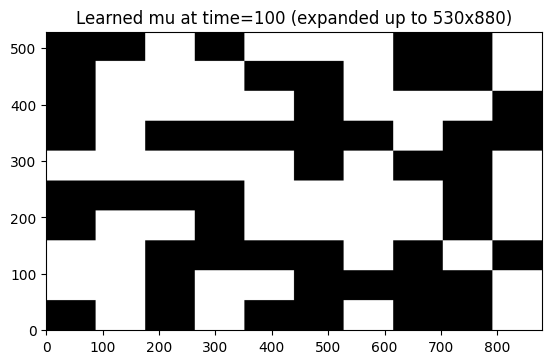

In [21]:
mu_full_np = model.expand_myu_full(do_binarize=False, scale_255=True)
print("mu_full_np shape:", mu_full_np.shape)  # (350,530,880)

# For a single time slice i=100:
import matplotlib.pyplot as plt

plt.imshow(mu_full_np[101], cmap='gray', origin='lower')
plt.title("Learned mu at time=100 (expanded up to 530x880)")
plt.show()

In [42]:
## Benchmarking

In [43]:
def build_npinp_model(
    Nt, Nx, Ny,
    Nx_down, Ny_down,
    dt, dx, dy,
    degrade_x, degrade_y,
    delta,
    weight_pde,
    device,
    layer_sizes=[3, 64, 64, 2],
    activation="tanh"
):
    """
    Build and return an NPINN_PRO_MAX model with the specified hyperparams.
    layer_sizes: list of integers, e.g. [3,64,64,2]
    activation: string to choose activation type
    """
    import torch.nn as nn

    # 1) Create a custom DNN class or inline code that uses the chosen activation
    #    We'll do it inline for brevity:

    class CustomDNN(nn.Module):
        def __init__(self, layer_sizes, act_type="tanh"):
            super().__init__()
            acts = {
                "tanh": nn.Tanh(),
                "relu": nn.ReLU(),
                "sigmoid": nn.Sigmoid(),
                "elu": nn.ELU(),
                # add more if you like
            }
            self.act = acts.get(act_type.lower(), nn.Tanh())

            modules = []
            for i in range(len(layer_sizes)-1):
                in_sz = layer_sizes[i]
                out_sz = layer_sizes[i+1]
                modules.append(nn.Linear(in_sz, out_sz))
                if i < len(layer_sizes)-2:
                    modules.append(self.act)
            self.net = nn.Sequential(*modules)

        def forward(self, x):
            return self.net(x)

    # 2) Build the DNN
    dnn = CustomDNN(layer_sizes, activation)

    # 3) Build the NPINN_PRO_MAX with our custom dnn
    model = NPINN_PRO_MAX(
        layers=None,  # we pass None or a dummy, since we manually give 'dnn' below
        Nt=Nt, Nx=Nx, Ny=Ny,
        Nx_down=Nx_down, Ny_down=Ny_down,
        dt=dt, dx=dx, dy=dy,
        degrade_x=degrade_x, degrade_y=degrade_y,
        delta=delta,
        weight_pde=weight_pde,
        device=device
    )

    # The trick: override 'model.dnn' with our custom net
    model.dnn = dnn.to(device)
    return model

In [ ]:
import itertools
import os

activations = ["tanh", "relu"]
pde_weights = [0.1, 1.0]
layer_size_options = [
    [3,64,64,2],
    [3,128,128,2]
]

# We'll store results in some base directory
base_output_dir = "./hyperparam_results"

for act, w_pde, layer_sizes in itertools.product(activations, pde_weights, layer_size_options):
    # 1) Build a descriptive name
    model_name = f"act_{act}_pde_{w_pde}_layers_{'-'.join(map(str, layer_sizes))}"
    print(f"\n=== Training: {model_name} ===")

    # 2) Build the model
    model = build_npinp_model(
        Nt=Nt, Nx=Nx, Ny=Ny,
        Nx_down=Nx_down, Ny_down=Ny_down,
        dt=dt, dx=dx, dy=dy,
        degrade_x=degrade_x, degrade_y=degrade_y,
        delta=0.01,
        weight_pde=w_pde,
        device=device,
        layer_sizes=layer_sizes,
        activation=act
    )

    # 3) Train the model with your updated train_model that can create videos + checkpoints
    #    Assume you have x_data_t, y_data_t, t_data_t, Ar_data_t, Ai_data_t, x_eqs_t, y_eqs_t, t_eqs_t
    model.train_model(
        x_data_t, y_data_t, t_data_t,
        Ar_data_t, Ai_data_t,
        x_eqs_t, y_eqs_t, t_eqs_t,
        n_epochs=200000,
        lr=1e-3,
        model_name=model_name,
        output_dir=base_output_dir,
        video_freq=100000,
        state_exp=state,
        myu_full_exp=myu_full,
        x_vals=x_vals,
        y_vals=y_vals,
        t_vals=t_vals,
        device=device
    )

    print(f"Finished training model: {model_name}")


In [49]:
import os
import itertools
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

#########################
##   MODEL FACTORY
#########################
def build_npinp_model(
    NPINNClass,         # e.g. NPINN_PRO_MAX
    custom_dnn_class,   # a function or class that returns a neural net with the chosen activation, etc.
    Nt, Nx, Ny,
    Nx_down, Ny_down,
    dt, dx, dy,
    degrade_x, degrade_y,
    delta,
    weight_pde,
    device,
    layer_sizes=[3, 64, 64, 2]
):
    """
    Create an instance of NPINNClass, overriding .dnn with a custom net of the chosen shape/activation.
    """
    # 1) Create the main model with some placeholders for 'layers'
    model = NPINNClass(
        layers=[3,1],  # or pass a dummy
        Nt=Nt, Nx=Nx, Ny=Ny,
        Nx_down=Nx_down, Ny_down=Ny_down,
        dt=dt, dx=dx, dy=dy,
        degrade_x=degrade_x, degrade_y=degrade_y,
        delta=delta,
        weight_pde=weight_pde,
        device=device
    )

    # 2) Build a DNN with the chosen layer sizes/activations
    net = custom_dnn_class(layer_sizes)
    model.dnn = net.to(device)
    return model


#########################
##   HELPER FOR CUSTOM NET
#########################
class CustomDNN(nn.Module):
    """A flexible MLP that picks an activation from a set of options."""
    def __init__(self, layer_sizes, activation="tanh"):
        super().__init__()
        acts = {
            "tanh": nn.Tanh(),
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "elu": nn.ELU(),
            "leakyrelu": nn.LeakyReLU(0.01),
            # add more if needed
        }
        chosen_act = acts.get(activation.lower(), nn.Tanh())

        modules = []
        for i in range(len(layer_sizes)-1):
            in_sz = layer_sizes[i]
            out_sz = layer_sizes[i+1]
            modules.append(nn.Linear(in_sz, out_sz))
            if i < len(layer_sizes)-2:
                modules.append(chosen_act)
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)


#########################
##   RUN EXPERIMENT
#########################
def run_experiment(
    model_name,
    model_class,        # e.g. NPINN_PRO_MAX
    custom_dnn_class,   # e.g. CustomDNN
    hyperparams,        # dict of needed fields: {Nt, Nx, Ny, Nx_down, Ny_down, dt, ...}
    training_conf,      # dict of fields for training loop: n_epochs, lr, ...
    data_conf,          # data & PDE collocation Tensors
    base_output_dir="./results"
):
    """
    1) Build a model with given hyperparams
    2) Train, using the model's .train_model(...) method
    3) Store results in base_output_dir/model_name
    """
    device = hyperparams["device"]

    # 1) Fix random seeds (if specified)
    seed = hyperparams.get("seed", 42)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # 2) Build the model
    model = build_npinp_model(
        NPINNClass=model_class,
        custom_dnn_class=lambda ls: custom_dnn_class(ls, activation=hyperparams["activation"]),
        Nt=hyperparams["Nt"], Nx=hyperparams["Nx"], Ny=hyperparams["Ny"],
        Nx_down=hyperparams["Nx_down"], Ny_down=hyperparams["Ny_down"],
        dt=hyperparams["dt"], dx=hyperparams["dx"], dy=hyperparams["dy"],
        degrade_x=hyperparams["degrade_x"], degrade_y=hyperparams["degrade_y"],
        delta=hyperparams["delta"],
        weight_pde=hyperparams["weight_pde"],
        device=device,
        layer_sizes=hyperparams["layer_sizes"]
    )

    # 3) Prepare output folder
    model_folder = os.path.join(base_output_dir, model_name)
    os.makedirs(model_folder, exist_ok=True)

    # 4) Unpack data_conf, e.g. x_data_t, y_data_t, t_data_t, ...
    x_data_t = data_conf["x_data_t"]
    y_data_t = data_conf["y_data_t"]
    t_data_t = data_conf["t_data_t"]
    Ar_data_t= data_conf["Ar_data_t"]
    Ai_data_t= data_conf["Ai_data_t"]
    x_eqs_t  = data_conf["x_eqs_t"]
    y_eqs_t  = data_conf["y_eqs_t"]
    t_eqs_t  = data_conf["t_eqs_t"]

    # Possibly the real experiment data for video:
    state_exp     = data_conf.get("state_exp", None)
    myu_full_exp  = data_conf.get("myu_full_exp", None)
    x_vals        = data_conf.get("x_vals", None)
    y_vals        = data_conf.get("y_vals", None)
    t_vals        = data_conf.get("t_vals", None)

    # 5) Train
    model.train_model(
        x_data_t, y_data_t, t_data_t, Ar_data_t, Ai_data_t,
        x_eqs_t,  y_eqs_t,  t_eqs_t,
        n_epochs=training_conf["n_epochs"],
        lr=training_conf["lr"],
        model_name=model_name,
        output_dir=base_output_dir,
        video_freq=training_conf.get("video_freq", 100000),
        state_exp=state_exp,
        myu_full_exp=myu_full_exp,
        x_vals=x_vals,
        y_vals=y_vals,
        t_vals=t_vals,
        device=device
    )

    print(f"=== Finished {model_name} ===\n")

    return model  # or you can return stats, etc.

In [50]:
import itertools

activations = ["tanh", "relu", "elu", "leakyrelu"]
layer_shapes = [
    [3, 64, 64, 2],
    [3, 128, 128, 2],
    [3, 64, 64, 64, 2]
]
pde_weights = [0.01, 0.1, 1.0]
learning_rates = [1e-3, 5e-4, 1e-4]
seeds = [42, 1337]

hyperparam_grids = list(itertools.product(
    activations,
    layer_shapes,
    pde_weights,
    learning_rates,
    seeds
))

print(f"Will train {len(hyperparam_grids)} different combos!")

Will train 216 different combos!


In [ ]:
# Suppose these are from your real or synthetic data pipeline
data_conf = {
    "x_data_t": x_data_t,
    "y_data_t": y_data_t,
    "t_data_t": t_data_t,
    "Ar_data_t": Ar_data_t,
    "Ai_data_t": Ai_data_t,
    "x_eqs_t": x_eqs_t,
    "y_eqs_t": y_eqs_t,
    "t_eqs_t": t_eqs_t,
    # For videos
    "state_exp": state,
    "myu_full_exp": myu_full,
    "x_vals": x_vals,
    "y_vals": y_vals,
    "t_vals": t_vals
}

training_conf = {
    "n_epochs": 200001,
    "video_freq": 100000,
    # lr is enumerated in the loop below
}

# Domain hyperparams
Nt, Nx, Ny = 350, 530, 880
Nx_down, Ny_down = 10, 10
dt, dx, dy = 0.05, 0.3, 0.3
degrade_x = Nx // Nx_down
degrade_y = Ny // Ny_down

for (activation, layer_sz, w_pde, lr, seed) in hyperparam_grids:
    # Build a name
    model_name = (
        f"Act_{activation}_Layers_{'-'.join(map(str,layer_sz))}"
        f"_wPDE_{w_pde}_LR_{lr}_seed_{seed}"
    )
    print(f"=== Now training {model_name} ===")

    # Build hyperparams
    hyperparams = {
        "Nt": Nt,
        "Nx": Nx,
        "Ny": Ny,
        "Nx_down": Nx_down,
        "Ny_down": Ny_down,
        "dt": dt,
        "dx": dx,
        "dy": dy,
        "degrade_x": degrade_x,
        "degrade_y": degrade_y,
        "delta": 0.01,
        "weight_pde": w_pde,
        "device": "cuda",
        "layer_sizes": layer_sz,
        "activation": activation,
        "seed": seed
    }

    # Overwrite the training_conf with the chosen lr
    train_conf = training_conf.copy()
    train_conf["lr"] = lr

    run_experiment(
        model_name=model_name,
        model_class=NPINN_PRO_MAX,   # or whichever class you use
        custom_dnn_class=CustomDNN, # the net builder
        hyperparams=hyperparams,
        training_conf=train_conf,
        data_conf=data_conf,
        base_output_dir="./BIG_SWEEP_RESULTS"
    )

=== Now training Act_tanh_Layers_3-64-64-2_wPDE_0.01_LR_0.001_seed_42 ===
Epoch=0, total=4.1164e-01, data=4.1119e-01, PDE=4.4396e-02
Epoch=500, total=2.0117e-01, data=2.0049e-01, PDE=6.7709e-02
Epoch=1000, total=1.9469e-01, data=1.9400e-01, PDE=6.8545e-02
Epoch=1500, total=1.9128e-01, data=1.9057e-01, PDE=7.0999e-02
Epoch=2000, total=1.8788e-01, data=1.8716e-01, PDE=7.2235e-02
Epoch=2500, total=1.8515e-01, data=1.8441e-01, PDE=7.4189e-02
Epoch=3000, total=1.8290e-01, data=1.8214e-01, PDE=7.5896e-02
Epoch=3500, total=1.8109e-01, data=1.8032e-01, PDE=7.6262e-02
Epoch=4000, total=1.7930e-01, data=1.7853e-01, PDE=7.7527e-02
Epoch=4500, total=1.8203e-01, data=1.8110e-01, PDE=9.3859e-02
Epoch=5000, total=1.7598e-01, data=1.7517e-01, PDE=8.0749e-02
Epoch=5500, total=1.7451e-01, data=1.7370e-01, PDE=8.0841e-02
Epoch=6000, total=1.7285e-01, data=1.7202e-01, PDE=8.2699e-02
Epoch=6500, total=1.7115e-01, data=1.7031e-01, PDE=8.3872e-02
Epoch=7000, total=1.6941e-01, data=1.6857e-01, PDE=8.3893e-02


In [10]:
import torch
import torch.nn as nn
import numpy as np

class DNN(nn.Module):
    """
    Simple MLP that maps (x,y,t)->(A_r, A_i).
    This is the same as before; you can incorporate different activation
    or layer structures as needed.
    """
    def __init__(self, layers):
        super().__init__()
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(nn.Tanh())
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)


class NPINN_PRO_MAX_CONTINUOUSMU(nn.Module):
    """
    A 'PINN' for the Complex Ginzburg–Landau equation, where:
      - A(x,y,t) is predicted by a small neural net (self.dnn).
      - mu_small_raw is a time-dependent 2D field in shape (Nt, Nx_down, Ny_down),
        but we do NOT binarize mu. It's fully continuous.

    PDE:
       A_t = mu A + delta Lap(A) - |A|^2 A

    The shape is:
      mu_small_raw: (Nt, Nx_down, Ny_down)
    We do a cell-based lookup:
      i = round(t/dt), j=(x/(dx*degrade_x)), k=(y/(dy*degrade_y))
    Then PDE sees that continuous value.

    The function expand_myu_full(...) can still be used to upsample
    the mu_small to (Nt, Nx, Ny) for visualization or direct comparison.
    """

    def __init__(
        self,
        layers,               # e.g. [3,64,64,2] for A_r, A_i
        Nt, Nx, Ny,           # full domain sizes
        Nx_down, Ny_down,     # smaller, downsampled domain for mu
        dt, dx, dy,
        degrade_x, degrade_y,
        delta=0.01,
        weight_pde=1.0,
        device='cpu'
    ):
        super().__init__()
        self.device = device
        self.delta = delta
        self.weight_pde = weight_pde

        # Basic domain sizes
        self.Nt, self.Nx, self.Ny = Nt, Nx, Ny
        self.Nx_down, self.Ny_down = Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy
        self.degrade_x, self.degrade_y = degrade_x, degrade_y

        # 1) The neural net for A(x,y,t)
        if layers is not None:
            self.dnn = DNN(layers).to(device)
        else:
            self.dnn = None  # to be overridden externally if needed

        # 2) The trainable mu_small: shape (Nt, Nx_down, Ny_down)
        init = 0.3 * torch.randn(Nt, Nx_down, Ny_down)
        self.mu_small_raw = nn.Parameter(init.to(device))

    def forward(self, x, y, t):
        """
        For convenience, you can do model(x,y,t)->(A_r,A_i).
        """
        return self.net_A(x, y, t)

    def net_A(self, x, y, t):
        """Forward pass for A_r, A_i."""
        if self.dnn is None:
            raise ValueError("No DNN assigned! You must define self.dnn or pass layers != None.")
        inp = torch.cat([x, y, t], dim=1)  # shape (batch,3)
        out = self.dnn(inp)               # shape (batch,2)
        A_r = out[:, 0:1]
        A_i = out[:, 1:2]
        return A_r, A_i

    def get_myu_collocation(self, x, y, t):
        """
        For PDE collocation: (x, y, t) -> integer indices (i, j_down, k_down).
        Return mu_small_raw[i,j_down,k_down] as a continuous scalar (no binarize).
        """
        i = (t[:,0] / self.dt).round().long().clamp(0, self.Nt-1)
        j_down = (x[:,0] / (self.dx*self.degrade_x)).floor().long()
        k_down = (y[:,0] / (self.dy*self.degrade_y)).floor().long()

        j_down = j_down.clamp(0, self.Nx_down-1)
        k_down = k_down.clamp(0, self.Ny_down-1)

        mu_vals_raw = self.mu_small_raw[i, j_down, k_down]
        # No threshold, purely continuous
        return mu_vals_raw.view(-1,1)

    def pde_residual(self, x, y, t):
        """
        PDE: A_t = mu*A + delta Lap(A) - |A|^2 A
        where mu = get_myu_collocation(x,y,t) (continuous).
        """
        A_r, A_i = self.net_A(x, y, t)
        mu_vals = self.get_myu_collocation(x, y, t)  # shape (batch,1)

        # partial derivatives wrt t
        A_r_t = torch.autograd.grad(A_r, t,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_t = torch.autograd.grad(A_i, t,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt x
        A_r_x = torch.autograd.grad(A_r, x,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_x = torch.autograd.grad(A_i, x,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt y
        A_r_y = torch.autograd.grad(A_r, y,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_y = torch.autograd.grad(A_i, y,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # second derivatives -> Laplacian
        A_r_xx = torch.autograd.grad(A_r_x, x,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True, retain_graph=True)[0]
        A_r_yy = torch.autograd.grad(A_r_y, y,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True, retain_graph=True)[0]

        A_i_xx = torch.autograd.grad(A_i_x, x,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True, retain_graph=True)[0]
        A_i_yy = torch.autograd.grad(A_i_y, y,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True, retain_graph=True)[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2

        f_r = A_r_t - mu_vals*A_r - self.delta*lapA_r + A_abs2*A_r
        f_i = A_i_t - mu_vals*A_i - self.delta*lapA_i + A_abs2*A_i
        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(self,
                    x_data, y_data, t_data, A_r_data, A_i_data,
                    x_eqs, y_eqs, t_eqs,
                    n_epochs=3000, lr=1e-3,
                    model_name="model",
                    output_dir="./results",
                    video_freq=10000,
                    state_exp=None,
                    myu_full_exp=None,
                    x_vals=None,
                    y_vals=None,
                    t_vals=None,
                    device='cpu'):
        import os
        import torch
        from datetime import datetime
        import numpy as np

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # Make a folder for logs
        model_folder = os.path.join(output_dir, model_name)
        os.makedirs(model_folder, exist_ok=True)

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            l_pde  = self.loss_pde(x_eqs, y_eqs, t_eqs)
            l_data = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss   = l_data + self.weight_pde*l_pde

            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch={epoch}, total={loss.item():.4e}, data={l_data.item():.4e}, PDE={l_pde.item():.4e}")

            # checkpoint + video if needed
            if (epoch % video_freq == 0 and epoch>0):
                ckpt_path = os.path.join(model_folder, f"{model_name}_epoch_{epoch}.pt")
                torch.save(self.state_dict(), ckpt_path)
                print(f"Checkpoint saved at {ckpt_path}")

                # If you want to generate a video comparing the model to real data
                if (state_exp is not None) and (myu_full_exp is not None) and (x_vals is not None) \
                   and (y_vals is not None) and (t_vals is not None):
                    # function generate_video(...) if you want
                    vid_name = f"{model_name}_epoch_{epoch}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
                    video_folder = os.path.join(model_folder, "videos")
                    os.makedirs(video_folder, exist_ok=True)

                    video_path = os.path.join(video_folder, vid_name)

                    generate_video(
                        state_exp,
                        myu_full_exp,
                        self,  # pass the model
                        x_vals, y_vals, t_vals,
                        device=device,
                        output_path=video_path
                    )

        # final checkpoint
        final_ckpt = os.path.join(model_folder, f"{model_name}_final_{n_epochs}.pt")
        torch.save(self.state_dict(), final_ckpt)
        print(f"Final checkpoint saved at {final_ckpt}\nTraining done.\n")


    def predict(self, x, y, t):
        """
        Evaluate the net for A(x,y,t) in eval mode, returning (A_r, A_i) as np arrays.
        """
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x, y, t)
        return A_r.cpu().numpy(), A_i.cpu().numpy()

    def expand_myu_full(self, clamp_range=None, scale_255=False):
        """
        Expand mu_small_raw to shape (Nt, Nx, Ny) by repeating each cell degrade_x, degrade_y times.
        If clamp_range is (low, high), we can clamp mu values between them.
        If scale_255, multiply by 255 after clamp or raw usage.

        Return shape = (Nt, Nx, Ny).
        """
        with torch.no_grad():
            mu_raw = self.mu_small_raw.detach().clone()  # shape (Nt, Nx_down, Ny_down)

            if clamp_range is not None:
                low, high = clamp_range
                mu_raw = torch.clamp(mu_raw, min=low, max=high)

            # Expand x, y dims
            mu_full_x = mu_raw.repeat_interleave(self.degrade_x, dim=1)
            mu_full_xy = mu_full_x.repeat_interleave(self.degrade_y, dim=2)

            if scale_255:
                mu_full_xy = mu_full_xy * 255.0

            return mu_full_xy.cpu().numpy()

In [11]:
import matplotlib.pyplot as plt

state = np.load("../data/test_new/states_processed_cropped.npy")
myu_full = np.load("../data/test_new/myus_binarized_processed_cropped.npy")

print("State shape:", state.shape, state.dtype)  # (350,530,880), complex128
print("Myu shape:  ", myu_full.shape, myu_full.dtype)  # (350,530,880), uint16

A_r_data = state.real
A_i_data = state.imag

Nt, Nx, Ny = state.shape
dt, dx, dy = 0.05, 0.3, 0.3  # Example values
Nx_down, Ny_down = 10, 10
degrade_x = Nx // Nx_down  # 530//10=53
degrade_y = Ny // Ny_down  # 880//10=88

model = NPINN_PRO_MAX_CONTINUOUSMU(
    layers=[3,64,64,2],
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda'
).to('cuda')


n_data = 20000
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

t_vals = np.arange(Nt) * dt
x_vals = np.arange(Nx) * dx
y_vals = np.arange(Ny) * dy

t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

import torch

device = 'cuda'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32, device=device).view(-1, 1)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32, device=device).view(-1, 1)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32, device=device).view(-1, 1)

n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

State shape: (350, 530, 880) complex128
Myu shape:   (350, 530, 880) uint16


In [12]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t, y_eqs_t, t_eqs_t,
    n_epochs=200001,
    lr=1e-3,
    model_name="BinaryMu_10x10_newarch",
    output_dir="./results",
    video_freq=20000,
    state_exp=state,  # for generating comparison video
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device='cuda'
)

Epoch=0, total=4.1941e-01, data=4.1830e-01, PDE=1.1084e-02


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                modules.append(nn.Softplus())
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        return self.net(x)

class NPINN_PRO_MAX_TIMEBLOCK(nn.Module):
    """
    A 'PINN' for the Complex Ginzburg–Landau equation, with both
    - time downsampling: degrade_t
    - x,y downsampling:  degrade_x, degrade_y
    - We interpret each mu_small_raw in shape (Nt_down, Nx_down, Ny_down).

    PDE: A_t = mu A + delta Lap(A) - |A|^2 A
    where mu is a BINARY field => 0 or 1, but stored as raw -> threshold in get_myu_collocation.

    'Time blocks': each coarse time index covers degrade_t frames in the full domain.
    """

    def __init__(
        self,
        layers,               # e.g. [3,64,64,2] for A_r, A_i
        Nt, Nx, Ny,           # full domain sizes
        Nx_down, Ny_down,     # smaller, downsampled domain for mu in x,y
        dt, dx, dy,
        degrade_x, degrade_y,
        degrade_t,            # <--- NEW: factor for time downsampling
        delta=0.01,
        weight_pde=1.0,
        device='cpu'
    ):
        super().__init__()
        self.device = device
        self.delta  = delta
        self.weight_pde = weight_pde

        # Full domain
        self.Nt, self.Nx, self.Ny = Nt, Nx, Ny
        self.Nx_down, self.Ny_down = Nx_down, Ny_down
        self.dt, self.dx, self.dy = dt, dx, dy
        self.degrade_x, self.degrade_y = degrade_x, degrade_y
        self.degrade_t = degrade_t

        # The reduced domain size in time
        # we assume Nt is divisible by degrade_t for simplicity
        self.Nt_down = Nt // degrade_t

        # 1) The neural net for A(x,y,t)
        self.dnn = DNN(layers).to(device)

        # 2) The trainable mu_small: shape (Nt_down, Nx_down, Ny_down).
        init = 0.3 * torch.randn(self.Nt_down, Nx_down, Ny_down)
        self.mu_small_raw = nn.Parameter(init.to(device))

    def forward(self, x, y, t):
        return self.net_A(x, y, t)

    def net_A(self, x, y, t):
        inp = torch.cat([x,y,t], dim=1)
        out = self.dnn(inp)
        A_r = out[:,0:1]
        A_i = out[:,1:2]
        return A_r, A_i

    def binarize_mu_small(self):
        """
        Hard threshold the entire mu_small_raw -> 0 or 1 in place.
        This is optional and breaks gradient flow.
        """
        with torch.no_grad():
            self.mu_small_raw.data = (self.mu_small_raw.data > 0.0).float()

    def get_myu_collocation(self, x, y, t):
        """
        (x,y,t) -> integer indices (i, j_down, k_down).
        But for time, we do i = floor(t/dt), then i_down = floor(i/degrade_t).
        Then threshold to 0/1.
        """
        # Convert t-> i in [0..Nt-1]
        i = (t[:,0] / self.dt).round().long().clamp(0, self.Nt-1)
        # Then the coarse time index
        i_down = (i // self.degrade_t).clamp(0, self.Nt_down-1)

        j_down = (x[:,0] / (self.dx*self.degrade_x)).floor().long()
        k_down = (y[:,0] / (self.dy*self.degrade_y)).floor().long()

        j_down = j_down.clamp(0, self.Nx_down-1)
        k_down = k_down.clamp(0, self.Ny_down-1)

        mu_vals_raw = self.mu_small_raw[i_down, j_down, k_down]
        # Binarize for PDE
        mu_bin = (mu_vals_raw > 0.0).float()  # shape (batch,)
        return mu_bin.view(-1,1)

    def pde_residual(self, x, y, t):
        A_r, A_i = self.net_A(x,y,t)
        mu_vals = self.get_myu_collocation(x,y,t)

        A_r_t = torch.autograd.grad(A_r, t,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_t = torch.autograd.grad(A_i, t,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt x
        A_r_x = torch.autograd.grad(A_r, x,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_x = torch.autograd.grad(A_i, x,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # wrt y
        A_r_y = torch.autograd.grad(A_r, y,
            grad_outputs=torch.ones_like(A_r),
            create_graph=True, retain_graph=True)[0]
        A_i_y = torch.autograd.grad(A_i, y,
            grad_outputs=torch.ones_like(A_i),
            create_graph=True, retain_graph=True)[0]

        # second derivatives
        A_r_xx = torch.autograd.grad(A_r_x, x,
            grad_outputs=torch.ones_like(A_r_x),
            create_graph=True, retain_graph=True)[0]
        A_r_yy = torch.autograd.grad(A_r_y, y,
            grad_outputs=torch.ones_like(A_r_y),
            create_graph=True, retain_graph=True)[0]

        A_i_xx = torch.autograd.grad(A_i_x, x,
            grad_outputs=torch.ones_like(A_i_x),
            create_graph=True, retain_graph=True)[0]
        A_i_yy = torch.autograd.grad(A_i_y, y,
            grad_outputs=torch.ones_like(A_i_y),
            create_graph=True, retain_graph=True)[0]

        lapA_r = A_r_xx + A_r_yy
        lapA_i = A_i_xx + A_i_yy

        A_abs2 = A_r**2 + A_i**2

        f_r = A_r_t - mu_vals*A_r - self.delta*lapA_r + A_abs2*A_r
        f_i = A_i_t - mu_vals*A_i - self.delta*lapA_i + A_abs2*A_i
        return f_r, f_i

    def loss_pde(self, x_eqs, y_eqs, t_eqs):
        f_r, f_i = self.pde_residual(x_eqs, y_eqs, t_eqs)
        return torch.mean(f_r**2 + f_i**2)

    def loss_data(self, x_data, y_data, t_data, A_r_data, A_i_data):
        A_r_pred, A_i_pred = self.net_A(x_data, y_data, t_data)
        return torch.mean((A_r_pred - A_r_data)**2 + (A_i_pred - A_i_data)**2)

    def train_model(
        self,
        x_data, y_data, t_data, A_r_data, A_i_data,
        x_eqs, y_eqs, t_eqs,
        n_epochs=200000,
        lr=1e-3,
        model_name="MyModel",
        output_dir="./results",
        video_freq=10000,
        state_exp=None,
        myu_full_exp=None,
        x_vals=None,
        y_vals=None,
        t_vals=None,
        device="cpu"
    ):
        import os
        from datetime import datetime

        optimizer = optim.Adam(self.parameters(), lr=lr)
        model_folder = os.path.join(output_dir, model_name)
        os.makedirs(model_folder, exist_ok=True)

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            pde_l  = self.loss_pde(x_eqs, y_eqs, t_eqs)
            data_l = self.loss_data(x_data, y_data, t_data, A_r_data, A_i_data)
            loss   = data_l + self.weight_pde*pde_l
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch={epoch}, total={loss.item():.4e}, data={data_l.item():.4e}, PDE={pde_l.item():.4e}")

            if (epoch % video_freq==0 and epoch>0):
                ckpt_path = os.path.join(model_folder, f"{model_name}_epoch_{epoch}.pt")
                torch.save(self.state_dict(), ckpt_path)
                print(f"Checkpoint saved at {ckpt_path}")

                # optional video
                if (state_exp is not None) and (myu_full_exp is not None) \
                   and (x_vals is not None) and (y_vals is not None) and (t_vals is not None):
                    vid_name = f"{model_name}_epoch_{epoch}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
                    video_folder = os.path.join(model_folder, "videos")
                    os.makedirs(video_folder, exist_ok=True)

                    video_path = os.path.join(video_folder, vid_name)
                    generate_video(
                        state_exp,
                        myu_full_exp,
                        self,
                        x_vals, y_vals, t_vals,
                        device=device,
                        output_path=video_path
                    )

        final_ckpt = os.path.join(model_folder, f"{model_name}_final_{n_epochs}.pt")
        torch.save(self.state_dict(), final_ckpt)
        print(f"Final checkpoint saved at {final_ckpt}\nTraining done.\n")

    def expand_myu_full(self, do_binarize=True, scale_255=False):
        """
        Expand mu_small_raw shape = (Nt_down, Nx_down, Ny_down)
        to full shape (Nt, Nx, Ny) by:
         1) repeat_interleave along time dim by degrade_t
         2) repeat_interleave along x,y dims by degrade_x, degrade_y
        """
        with torch.no_grad():
            mu_raw = self.mu_small_raw.detach()  # shape (Nt_down, Nx_down, Ny_down)

            if do_binarize:
                mu_bin = (mu_raw>0.0).float()
            else:
                mu_bin = mu_raw

            # time expansion
            mu_time = mu_bin.repeat_interleave(self.degrade_t, dim=0)
            # shape => (Nt_down*degrade_t, Nx_down, Ny_down) = (Nt, Nx_down, Ny_down)

            # expand in x,y
            mu_full_x = mu_time.repeat_interleave(self.degrade_x, dim=1)
            mu_full_xy = mu_full_x.repeat_interleave(self.degrade_y, dim=2)

            if scale_255:
                mu_full_xy = mu_full_xy * 255.0

            return mu_full_xy.cpu().numpy()

    def predict(self, x, y, t):
        self.eval()
        with torch.no_grad():
            A_r, A_i = self.net_A(x, y, t)
        return A_r.cpu().numpy(), A_i.cpu().numpy()


In [14]:

state = np.load("../data/test_new/states_processed_cropped.npy")
myu_full = np.load("../data/test_new/myus_binarized_processed_cropped.npy")

print("State shape:", state.shape, state.dtype)  # (350,530,880), complex128
print("Myu shape:  ", myu_full.shape, myu_full.dtype)  # (350,530,880), uint16

A_r_data = state.real
A_i_data = state.imag

Nt, Nx, Ny = state.shape
dt, dx, dy = 0.05, 0.3, 0.3  # Example values
Nx_down, Ny_down = 10, 10
degrade_x = Nx // Nx_down  # 530//10=53
degrade_y = Ny // Ny_down  # 880//10=88

State shape: (350, 530, 880) complex128
Myu shape:   (350, 530, 880) uint16


In [15]:
model = NPINN_PRO_MAX_TIMEBLOCK(
    layers=[3,64,64,2],
    Nt=Nt, Nx=Nx, Ny=Ny,
    Nx_down=Nx_down, Ny_down=Ny_down,
    dt=dt, dx=dx, dy=dy,
    degrade_x=degrade_x, degrade_y=degrade_y,
    delta=0.01,
    weight_pde=0.1,
    device='cuda',
    degrade_t=50
)
model.to('cuda')

NPINN_PRO_MAX_TIMEBLOCK(
  (dnn): DNN(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [16]:
n_data = 20000
idx_t = np.random.randint(0, Nt, size=n_data)
idx_x = np.random.randint(0, Nx, size=n_data)
idx_y = np.random.randint(0, Ny, size=n_data)

t_vals = np.arange(Nt) * dt
x_vals = np.arange(Nx) * dx
y_vals = np.arange(Ny) * dy

t_data_np = t_vals[idx_t]
x_data_np = x_vals[idx_x]
y_data_np = y_vals[idx_y]

Ar_data_np = A_r_data[idx_t, idx_x, idx_y]
Ai_data_np = A_i_data[idx_t, idx_x, idx_y]

import torch

device = 'cuda'

x_data_t = torch.tensor(x_data_np, dtype=torch.float32, device=device).view(-1, 1)
y_data_t = torch.tensor(y_data_np, dtype=torch.float32, device=device).view(-1, 1)
t_data_t = torch.tensor(t_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ar_data_t = torch.tensor(Ar_data_np, dtype=torch.float32, device=device).view(-1, 1)
Ai_data_t = torch.tensor(Ai_data_np, dtype=torch.float32, device=device).view(-1, 1)

n_coll = 20000
t_eqs_np = np.random.uniform(0, t_vals[-1], size=n_coll)
x_eqs_np = np.random.uniform(0, x_vals[-1], size=n_coll)
y_eqs_np = np.random.uniform(0, y_vals[-1], size=n_coll)

x_eqs_t = torch.tensor(x_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
y_eqs_t = torch.tensor(y_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)
t_eqs_t = torch.tensor(t_eqs_np, dtype=torch.float32, device=device, requires_grad=True).view(-1, 1)

In [17]:
model.train_model(
    x_data_t, y_data_t, t_data_t,
    Ar_data_t, Ai_data_t,
    x_eqs_t, y_eqs_t, t_eqs_t,
    n_epochs=200001,
    lr=1e-3,
    model_name="TimeBlockerTestMyu",
    output_dir="./results",
    video_freq=10000,
    state_exp=state,  # for generating comparison video
    myu_full_exp=myu_full,
    x_vals=x_vals,
    y_vals=y_vals,
    t_vals=t_vals,
    device='cuda')

Epoch=0, total=3.0527e-01, data=3.0288e-01, PDE=2.3886e-02
Epoch=500, total=2.0566e-01, data=1.9962e-01, PDE=6.0417e-02
Epoch=1000, total=2.0223e-01, data=1.9636e-01, PDE=5.8743e-02
Epoch=1500, total=1.9786e-01, data=1.9150e-01, PDE=6.3605e-02
Epoch=2000, total=1.9628e-01, data=1.8986e-01, PDE=6.4223e-02
Epoch=2500, total=1.9512e-01, data=1.8868e-01, PDE=6.4322e-02
Epoch=3000, total=1.9364e-01, data=1.8710e-01, PDE=6.5449e-02
Epoch=3500, total=1.9212e-01, data=1.8545e-01, PDE=6.6724e-02
Epoch=4000, total=1.9071e-01, data=1.8401e-01, PDE=6.7051e-02
Epoch=4500, total=1.8960e-01, data=1.8286e-01, PDE=6.7440e-02
Epoch=5000, total=1.9027e-01, data=1.8349e-01, PDE=6.7821e-02
Epoch=5500, total=1.8748e-01, data=1.8064e-01, PDE=6.8435e-02
Epoch=6000, total=1.8644e-01, data=1.7957e-01, PDE=6.8637e-02
Epoch=6500, total=1.8536e-01, data=1.7841e-01, PDE=6.9539e-02
Epoch=7000, total=1.8439e-01, data=1.7747e-01, PDE=6.9173e-02
Epoch=7500, total=1.8343e-01, data=1.7651e-01, PDE=6.9146e-02
Epoch=8000, 

Creating video: 100%|██████████| 350/350 [01:00<00:00,  5.77it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_10000_20250121134139\output_video_20250121134144.mp4
Epoch=10500, total=1.7825e-01, data=1.7108e-01, PDE=7.1775e-02
Epoch=11000, total=1.7742e-01, data=1.7018e-01, PDE=7.2325e-02
Epoch=11500, total=2.0674e-01, data=2.0026e-01, PDE=6.4754e-02
Epoch=12000, total=1.7566e-01, data=1.6840e-01, PDE=7.2572e-02
Epoch=12500, total=1.7473e-01, data=1.6744e-01, PDE=7.2927e-02
Epoch=13000, total=1.7696e-01, data=1.6908e-01, PDE=7.8875e-02
Epoch=13500, total=1.7312e-01, data=1.6577e-01, PDE=7.3487e-02
Epoch=14000, total=1.7231e-01, data=1.6493e-01, PDE=7.3827e-02
Epoch=14500, total=1.7149e-01, data=1.6408e-01, PDE=7.4138e-02
Epoch=15000, total=1.7066e-01, data=1.6322e-01, PDE=7.4412e-02
Epoch=15500, total=1.8404e-01, data=1.7477e-01, PDE=9.2705e-02
Epoch=16000, total=1.6899e-01, data=1.6148e-01, PDE=7.5105e-02
Epoch=16500, total=1.8074e-01, data=1.7078e-01, PDE=9.9576e-02
Epoch=17000, total=1.6739e-01, data=1.5990e-01, PDE

Creating video: 100%|██████████| 350/350 [00:59<00:00,  5.88it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_20000_20250121134457\output_video_20250121134501.mp4
Epoch=20500, total=1.6414e-01, data=1.5542e-01, PDE=8.7181e-02
Epoch=21000, total=1.6162e-01, data=1.5377e-01, PDE=7.8438e-02
Epoch=21500, total=1.6113e-01, data=1.5289e-01, PDE=8.2444e-02
Epoch=22000, total=1.6013e-01, data=1.5190e-01, PDE=8.2251e-02
Epoch=22500, total=1.5915e-01, data=1.5117e-01, PDE=7.9801e-02
Epoch=23000, total=1.5848e-01, data=1.5045e-01, PDE=8.0265e-02
Epoch=23500, total=1.6095e-01, data=1.5241e-01, PDE=8.5404e-02
Epoch=24000, total=1.5719e-01, data=1.4910e-01, PDE=8.0845e-02
Epoch=24500, total=1.5724e-01, data=1.4943e-01, PDE=7.8063e-02
Epoch=25000, total=1.5606e-01, data=1.4797e-01, PDE=8.0987e-02
Epoch=25500, total=1.5546e-01, data=1.4746e-01, PDE=7.9982e-02
Epoch=26000, total=1.5516e-01, data=1.4684e-01, PDE=8.3262e-02
Epoch=26500, total=1.5422e-01, data=1.4602e-01, PDE=8.2065e-02
Epoch=27000, total=1.5371e-01, data=1.4546e-01, PDE

Creating video: 100%|██████████| 350/350 [01:06<00:00,  5.30it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_30000_20250121134823\output_video_20250121134828.mp4
Epoch=30500, total=1.5065e-01, data=1.4220e-01, PDE=8.4494e-02
Epoch=31000, total=1.5020e-01, data=1.4187e-01, PDE=8.3310e-02
Epoch=31500, total=1.4979e-01, data=1.4140e-01, PDE=8.3963e-02
Epoch=32000, total=1.5075e-01, data=1.4289e-01, PDE=7.8610e-02
Epoch=32500, total=1.4946e-01, data=1.4065e-01, PDE=8.8127e-02
Epoch=33000, total=1.4864e-01, data=1.4014e-01, PDE=8.5006e-02
Epoch=33500, total=1.4918e-01, data=1.4116e-01, PDE=8.0201e-02
Epoch=34000, total=1.4804e-01, data=1.3961e-01, PDE=8.4321e-02
Epoch=34500, total=1.4781e-01, data=1.3914e-01, PDE=8.6649e-02
Epoch=35000, total=1.4729e-01, data=1.3893e-01, PDE=8.3566e-02
Epoch=35500, total=1.4679e-01, data=1.3819e-01, PDE=8.6012e-02
Epoch=36000, total=1.4784e-01, data=1.3951e-01, PDE=8.3288e-02
Epoch=36500, total=1.4892e-01, data=1.4114e-01, PDE=7.7790e-02
Epoch=37000, total=1.4577e-01, data=1.3721e-01, PDE

Creating video: 100%|██████████| 350/350 [01:14<00:00,  4.72it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_40000_20250121135310\output_video_20250121135315.mp4
Epoch=40500, total=1.4479e-01, data=1.3538e-01, PDE=9.4031e-02
Epoch=41000, total=1.4331e-01, data=1.3453e-01, PDE=8.7822e-02
Epoch=41500, total=1.4334e-01, data=1.3471e-01, PDE=8.6301e-02
Epoch=42000, total=1.4276e-01, data=1.3400e-01, PDE=8.7567e-02
Epoch=42500, total=1.4249e-01, data=1.3363e-01, PDE=8.8585e-02
Epoch=43000, total=1.4239e-01, data=1.3357e-01, PDE=8.8187e-02
Epoch=43500, total=1.4256e-01, data=1.3362e-01, PDE=8.9405e-02
Epoch=44000, total=1.4171e-01, data=1.3286e-01, PDE=8.8488e-02
Epoch=44500, total=1.4217e-01, data=1.3299e-01, PDE=9.1853e-02
Epoch=45000, total=1.4134e-01, data=1.3232e-01, PDE=9.0241e-02
Epoch=45500, total=1.4106e-01, data=1.3229e-01, PDE=8.7760e-02
Epoch=46000, total=1.4069e-01, data=1.3177e-01, PDE=8.9157e-02
Epoch=46500, total=1.4045e-01, data=1.3151e-01, PDE=8.9409e-02
Epoch=47000, total=1.4211e-01, data=1.3283e-01, PDE

Creating video: 100%|██████████| 350/350 [01:23<00:00,  4.17it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_50000_20250121135814\output_video_20250121135819.mp4
Epoch=50500, total=1.3857e-01, data=1.2955e-01, PDE=9.0219e-02
Epoch=51000, total=1.3937e-01, data=1.3060e-01, PDE=8.7733e-02
Epoch=51500, total=1.3814e-01, data=1.2907e-01, PDE=9.0644e-02
Epoch=52000, total=1.3793e-01, data=1.2883e-01, PDE=9.1053e-02
Epoch=52500, total=1.3825e-01, data=1.2928e-01, PDE=8.9700e-02
Epoch=53000, total=1.4307e-01, data=1.3244e-01, PDE=1.0633e-01
Epoch=53500, total=1.3998e-01, data=1.3160e-01, PDE=8.3755e-02
Epoch=54000, total=1.3713e-01, data=1.2794e-01, PDE=9.1861e-02
Epoch=54500, total=1.3692e-01, data=1.2775e-01, PDE=9.1716e-02
Epoch=55000, total=1.3715e-01, data=1.2801e-01, PDE=9.1384e-02
Epoch=55500, total=1.3654e-01, data=1.2745e-01, PDE=9.0935e-02
Epoch=56000, total=1.3670e-01, data=1.2741e-01, PDE=9.2845e-02
Epoch=56500, total=1.3622e-01, data=1.2694e-01, PDE=9.2756e-02
Epoch=57000, total=1.3604e-01, data=1.2679e-01, PDE

Creating video: 100%|██████████| 350/350 [01:27<00:00,  4.02it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_60000_20250121140330\output_video_20250121140335.mp4
Epoch=60500, total=1.3490e-01, data=1.2584e-01, PDE=9.0534e-02
Epoch=61000, total=1.3467e-01, data=1.2528e-01, PDE=9.3888e-02
Epoch=61500, total=1.3444e-01, data=1.2519e-01, PDE=9.2443e-02
Epoch=62000, total=1.3436e-01, data=1.2498e-01, PDE=9.3838e-02
Epoch=62500, total=1.3413e-01, data=1.2478e-01, PDE=9.3536e-02
Epoch=63000, total=1.3398e-01, data=1.2464e-01, PDE=9.3376e-02
Epoch=63500, total=1.3404e-01, data=1.2488e-01, PDE=9.1625e-02
Epoch=64000, total=1.3367e-01, data=1.2434e-01, PDE=9.3362e-02
Epoch=64500, total=1.3597e-01, data=1.2718e-01, PDE=8.7902e-02
Epoch=65000, total=1.3360e-01, data=1.2446e-01, PDE=9.1417e-02
Epoch=65500, total=1.3331e-01, data=1.2394e-01, PDE=9.3713e-02
Epoch=66000, total=1.3352e-01, data=1.2385e-01, PDE=9.6699e-02
Epoch=66500, total=1.3299e-01, data=1.2363e-01, PDE=9.3566e-02
Epoch=67000, total=1.3286e-01, data=1.2349e-01, PDE

Creating video: 100%|██████████| 350/350 [01:22<00:00,  4.22it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_70000_20250121140848\output_video_20250121140853.mp4
Epoch=70500, total=1.3495e-01, data=1.2624e-01, PDE=8.7162e-02
Epoch=71000, total=1.3195e-01, data=1.2261e-01, PDE=9.3339e-02
Epoch=71500, total=1.3210e-01, data=1.2292e-01, PDE=9.1806e-02
Epoch=72000, total=1.3183e-01, data=1.2257e-01, PDE=9.2679e-02
Epoch=72500, total=1.3188e-01, data=1.2272e-01, PDE=9.1597e-02
Epoch=73000, total=1.3150e-01, data=1.2203e-01, PDE=9.4629e-02
Epoch=73500, total=1.3140e-01, data=1.2190e-01, PDE=9.4972e-02
Epoch=74000, total=1.3131e-01, data=1.2193e-01, PDE=9.3777e-02
Epoch=74500, total=1.3178e-01, data=1.2266e-01, PDE=9.1182e-02
Epoch=75000, total=1.3119e-01, data=1.2177e-01, PDE=9.4157e-02
Epoch=75500, total=1.3102e-01, data=1.2163e-01, PDE=9.3895e-02
Epoch=76000, total=1.3119e-01, data=1.2148e-01, PDE=9.7071e-02
Epoch=76500, total=1.3084e-01, data=1.2138e-01, PDE=9.4548e-02
Epoch=77000, total=1.3174e-01, data=1.2228e-01, PDE

Creating video: 100%|██████████| 350/350 [01:23<00:00,  4.21it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_80000_20250121141339\output_video_20250121141351.mp4
Epoch=80500, total=1.3023e-01, data=1.2071e-01, PDE=9.5297e-02
Epoch=81000, total=1.3007e-01, data=1.2062e-01, PDE=9.4545e-02
Epoch=81500, total=1.3034e-01, data=1.2085e-01, PDE=9.4960e-02
Epoch=82000, total=1.2986e-01, data=1.2035e-01, PDE=9.5089e-02
Epoch=82500, total=1.2978e-01, data=1.2020e-01, PDE=9.5740e-02
Epoch=83000, total=1.2989e-01, data=1.2010e-01, PDE=9.7884e-02
Epoch=83500, total=1.2961e-01, data=1.2007e-01, PDE=9.5394e-02
Epoch=84000, total=1.2955e-01, data=1.2007e-01, PDE=9.4793e-02
Epoch=84500, total=1.3032e-01, data=1.2100e-01, PDE=9.3230e-02
Epoch=85000, total=1.3089e-01, data=1.2126e-01, PDE=9.6361e-02
Epoch=85500, total=1.2937e-01, data=1.1989e-01, PDE=9.4802e-02
Epoch=86000, total=1.2923e-01, data=1.1966e-01, PDE=9.5693e-02
Epoch=86500, total=1.2921e-01, data=1.1973e-01, PDE=9.4746e-02
Epoch=87000, total=1.2966e-01, data=1.2041e-01, PDE

Creating video: 100%|██████████| 350/350 [01:22<00:00,  4.23it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_90000_20250121141820\output_video_20250121141825.mp4
Epoch=90500, total=1.2861e-01, data=1.1901e-01, PDE=9.5945e-02
Epoch=91000, total=1.2859e-01, data=1.1906e-01, PDE=9.5245e-02
Epoch=91500, total=1.2860e-01, data=1.1899e-01, PDE=9.6103e-02
Epoch=92000, total=1.2935e-01, data=1.1947e-01, PDE=9.8794e-02
Epoch=92500, total=1.2833e-01, data=1.1872e-01, PDE=9.6086e-02
Epoch=93000, total=1.2860e-01, data=1.1886e-01, PDE=9.7401e-02
Epoch=93500, total=1.2853e-01, data=1.1875e-01, PDE=9.7868e-02
Epoch=94000, total=1.2814e-01, data=1.1851e-01, PDE=9.6252e-02
Epoch=94500, total=1.2807e-01, data=1.1844e-01, PDE=9.6287e-02
Epoch=95000, total=1.2838e-01, data=1.1849e-01, PDE=9.8834e-02
Epoch=95500, total=1.2795e-01, data=1.1834e-01, PDE=9.6109e-02
Epoch=96000, total=1.2789e-01, data=1.1831e-01, PDE=9.5844e-02
Epoch=96500, total=1.2791e-01, data=1.1823e-01, PDE=9.6764e-02
Epoch=97000, total=1.2781e-01, data=1.1804e-01, PDE

Creating video: 100%|██████████| 350/350 [01:06<00:00,  5.25it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_100000_20250121142213\output_video_20250121142218.mp4
Epoch=100500, total=1.2740e-01, data=1.1774e-01, PDE=9.6571e-02
Epoch=101000, total=1.2730e-01, data=1.1766e-01, PDE=9.6434e-02
Epoch=101500, total=1.2746e-01, data=1.1770e-01, PDE=9.7615e-02
Epoch=102000, total=1.2721e-01, data=1.1748e-01, PDE=9.7375e-02
Epoch=102500, total=1.2724e-01, data=1.1749e-01, PDE=9.7528e-02
Epoch=103000, total=1.2709e-01, data=1.1735e-01, PDE=9.7389e-02
Epoch=103500, total=1.2701e-01, data=1.1731e-01, PDE=9.6994e-02
Epoch=104000, total=1.2705e-01, data=1.1740e-01, PDE=9.6462e-02
Epoch=104500, total=1.2858e-01, data=1.1868e-01, PDE=9.9003e-02
Epoch=105000, total=1.2697e-01, data=1.1723e-01, PDE=9.7407e-02
Epoch=105500, total=1.2775e-01, data=1.1841e-01, PDE=9.3380e-02
Epoch=106000, total=1.2704e-01, data=1.1752e-01, PDE=9.5168e-02
Epoch=106500, total=1.2669e-01, data=1.1703e-01, PDE=9.6574e-02
Epoch=107000, total=1.2694e-01, data=

Creating video: 100%|██████████| 350/350 [01:12<00:00,  4.84it/s]


Video saved at: ./results\TimeBlockerTestMyu\videos\TimeBlockerTestMyu_epoch_110000_20250121142546\output_video_20250121142551.mp4
Epoch=110500, total=1.2627e-01, data=1.1657e-01, PDE=9.6991e-02
Epoch=111000, total=1.2626e-01, data=1.1662e-01, PDE=9.6366e-02
Epoch=111500, total=1.2628e-01, data=1.1665e-01, PDE=9.6314e-02
Epoch=112000, total=1.2611e-01, data=1.1640e-01, PDE=9.7124e-02
Epoch=112500, total=1.2661e-01, data=1.1652e-01, PDE=1.0093e-01
Epoch=113000, total=1.2602e-01, data=1.1627e-01, PDE=9.7437e-02
Epoch=113500, total=1.2607e-01, data=1.1651e-01, PDE=9.5524e-02
Epoch=114000, total=1.2600e-01, data=1.1635e-01, PDE=9.6487e-02
Epoch=114500, total=1.2586e-01, data=1.1613e-01, PDE=9.7282e-02
Epoch=115000, total=1.2586e-01, data=1.1602e-01, PDE=9.8367e-02
Epoch=115500, total=1.2577e-01, data=1.1601e-01, PDE=9.7533e-02
Epoch=116000, total=1.2573e-01, data=1.1600e-01, PDE=9.7230e-02


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`